# Elastic Net

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), it performs a regression with both $L_1$ and $L_2$ regularizations. Therefore, it tries to minimize the following quantity
$$ \frac{1}{2 * n_{samples}} ||y - Xw||^2_2 + \alpha  \rho ||w||_1 + \frac{\alpha (1 - \rho)}{2}||w||_2, $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ is the regularization. The parameter $\rho$ is the ratio of $L_1$ regularization. 

This means that ElasticNet is appropriate to deal with sparsity, as in the Lasso regularization, while maintaining the stability under rotation of the Ridge regularization. In presence of correlated features, Lasso tends to pick one of them randomly, while ElasticNet will most likely pick both.

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model, grid_results

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/02_linear_models.csv'  # for storing results
modelname='ElasticNet'
kfolds = KFold(10, shuffle=True, random_state=541)

In [2]:
ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

# Hyperparameters and their role

* **alpha**: the regularization. It must be positive. When set to 0, we get the simple Linear regression, but it is not advised for numerical reasons. It is a linear combination of the Lasso and Ridge alpha's.
* **l1_ratio**: a number between 0 and 1 to control the mix between $L_1$ and $L_2$ regularizations. When 0, we have the $L_2$ penalty. When 1, we have the $L_1$ penalty.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that controls the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **positive**: when True, it forces the coefficients to be positive.
* **precompute**: Whether to use a precomputed Gram matrix to speed up calculations. 
* **random_state**: relevant only if the selection is random
* **selection**: if set to 'random', a random coefficient is updated every iteration rather than looping over features sequentially. It can speed up the convergence.
* **tol**: the precision of the solution
* **warm_start**: if True, it reuses the previously fitted model to initialize again. This can be useful in a grid search, where you can reuse aspects of the model learnt from the previous parameter value and thus save time.

Once again, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, l1_ratio, positivity and selection of the coefficients. The effect of the other hyperparameters was already explored in Notebook 4.

In [3]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.1, 5, 0.05)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05), 
              'net__selection': ['cyclic', 'random'], 
              'net__positive': [True, False]}

res = grid_results(model, kfolds, param_grid, data_name='data/simulated/100_feat_65_inf_nonoise.csv', sample=500)

res.head()

{'net__alpha': 0.1, 'net__l1_ratio': 0.9500000000000001, 'net__positive': True, 'net__selection': 'cyclic'}


param_net__alpha param_net__l1_ratio param_net__positive  \
0              0.1                0.95                True   
1              0.1                0.95                True   
2              0.1                0.95               False   
3              0.1                0.95               False   
4             0.15                0.95                True   

  param_net__selection  mean_train_score  std_train_score  mean_test_score  \
0               cyclic         -2.385067         0.037966        -2.872974   
1               random         -2.386382         0.037901        -2.874033   
2               cyclic         -2.401148         0.037955        -2.969271   
3               random         -2.402299         0.038602        -2.970307   
4               cyclic         -3.565979         0.056399        -4.292126   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.412640       0.004469      0.000152         0.001566   
1        0.412368       0.004761      0.000067         0.001595   
2        0.434639       0.004551      0.000200         0.001583   
3        0.436032       0.004778      0.000128         0.001626   
4        0.614775       0.004479      0.000099         0.001586   

   std_score_time  
0        0.000046  
1        0.000033  
2        0.000092  
3        0.000075  
4        0.000017

If before we have seen a slightly faster model when the selection was random, this time we see that a cyclic selection si a bit faster.

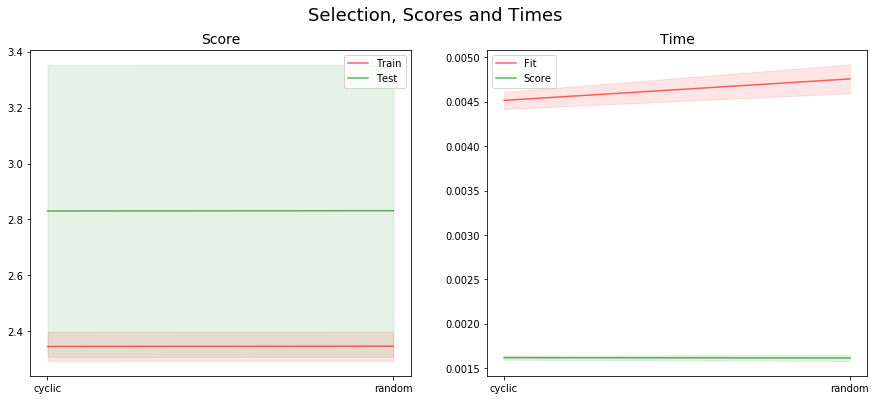

In [9]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.1) & 
                            (res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__positive==True)], 'param_net__selection', 'Selection')

On the other hand, the hyperparameter `positive`, while being very important in terms of model interpretability, is not playing a role in terms of performance or speed, although the fluctuations in training time are much higher when it is set to True

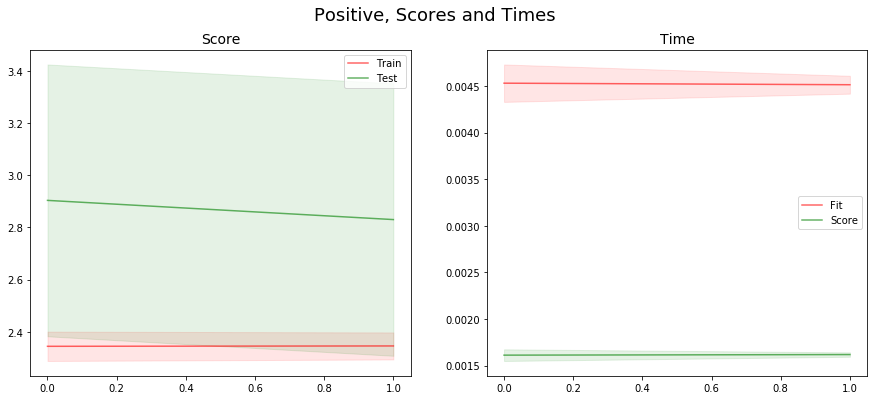

In [10]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.1) & 
                            (res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__selection=='cyclic')], 'param_net__positive', 'Positive')

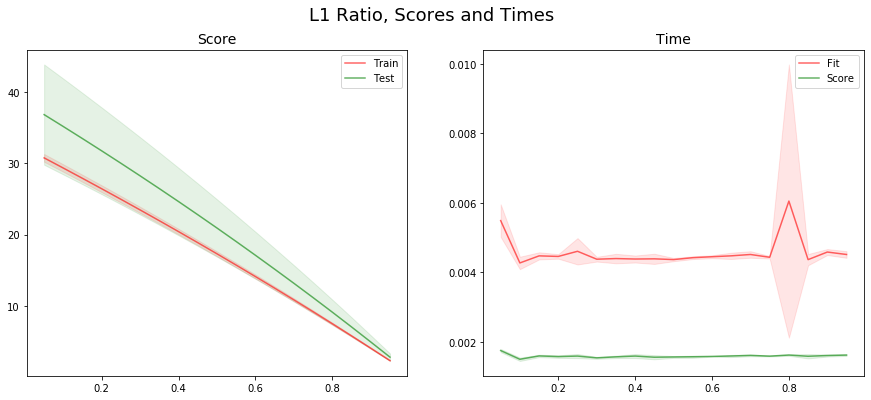

In [13]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.1) & 
                            (res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==True)], 'param_net__l1_ratio', 'L1 Ratio')

The most important hyperparameter is `alpha`, the regularizing term. As we have seen in the previous notebook, **more regularization leads to learning the training data less and less**. In the case of Lasso regularization, this means setting to 0 more and more coefficients and, on this set of data, this means having a model that has a worse and worse performance the more we regularize.

In [ ]:
hyp.plot_hyperparameter(res[(res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==True)], 'param_net__alpha', 'Alpha')

The last parameter is the tolerance and we can see in this joint plot that its importance is very limited, compared to the role of `alpha`.

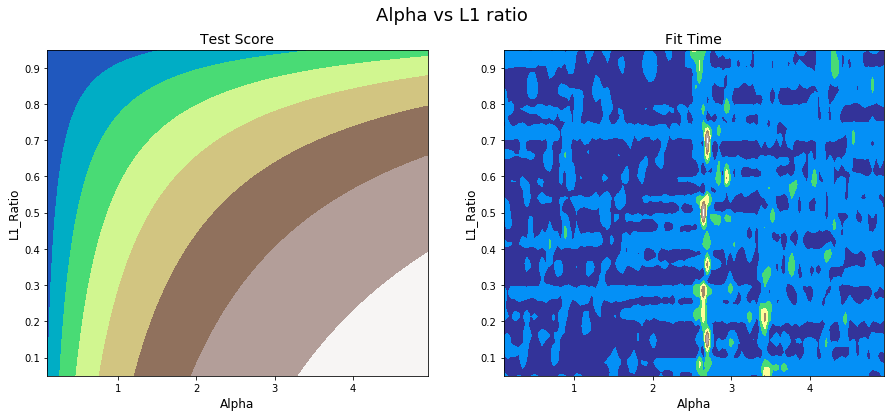

In [14]:
hyp.plot_two_hyperparms(res[(res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==True)], 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 ratio')

In order to not move to the next section with a partial view of the hyperparameters role, we test the model on a different set of data

In [15]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.1, 5, 0.05)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05), 
              'net__selection': ['cyclic', 'random'], 
              'net__positive': [True, False]}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=1000)

res.head()

{'net__alpha': 0.5000000000000001, 'net__l1_ratio': 0.9500000000000001, 'net__positive': False, 'net__selection': 'cyclic'}


param_net__alpha param_net__l1_ratio param_net__positive  \
0              0.5                0.95               False   
1             0.55                0.95               False   
2              0.6                0.95               False   
3             0.45                0.95               False   
4             0.65                0.95               False   

  param_net__selection  mean_train_score  std_train_score  mean_test_score  \
0               cyclic        -12.394006         0.084385       -13.257811   
1               cyclic        -12.417064         0.085261       -13.258034   
2               cyclic        -12.440162         0.085306       -13.260385   
3               cyclic        -12.368969         0.083715       -13.261100   
4               cyclic        -12.464364         0.085098       -13.266678   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.777620       0.008343      0.000528         0.002000   
1        0.781824       0.008706      0.000762         0.002129   
2        0.785088       0.009201      0.000593         0.002000   
3        0.773313       0.009627      0.001184         0.003502   
4        0.789324       0.009902      0.001259         0.001980   

   std_score_time  
0        0.000057  
1        0.000241  
2        0.000105  
3        0.001720  
4        0.000077

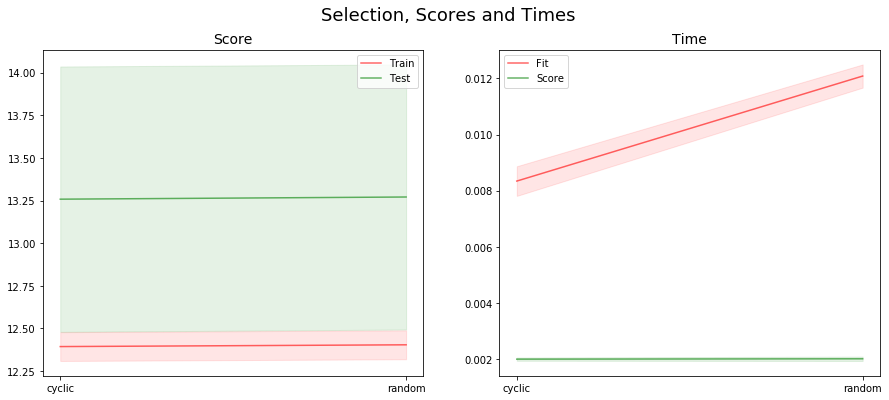

In [16]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.5000000000000001) & 
                            (res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__positive==False)], 'param_net__selection', 'Selection')

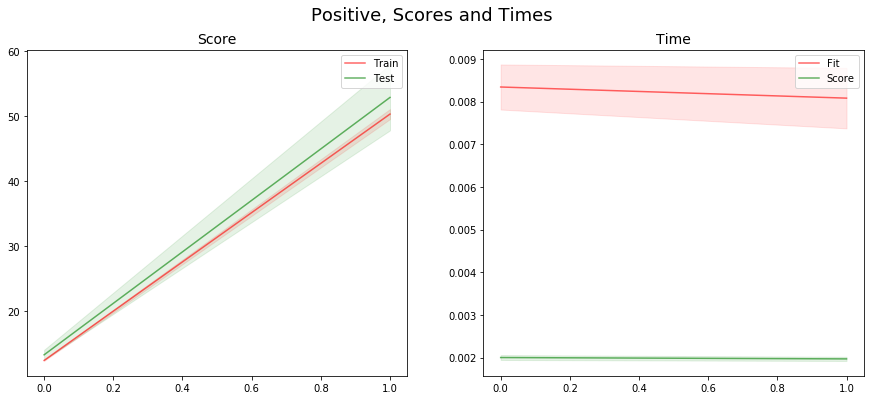

In [17]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.5000000000000001) & 
                            (res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__selection=='cyclic')], 'param_net__positive', 'Positive')

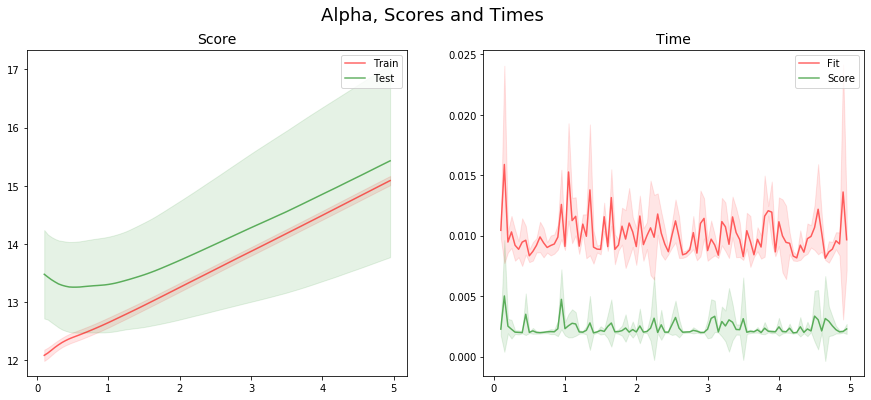

In [18]:
hyp.plot_hyperparameter(res[(res.param_net__l1_ratio==0.9500000000000001) & 
                            (res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==False)], 'param_net__alpha', 'Alpha')

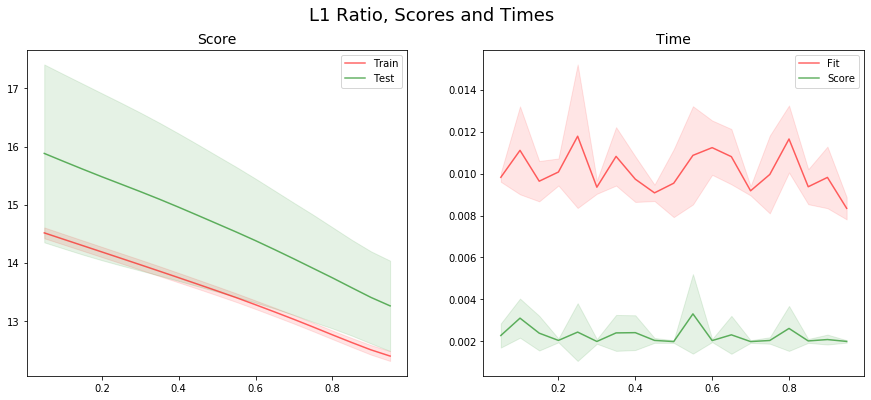

In [19]:
hyp.plot_hyperparameter(res[(res.param_net__alpha == 0.5000000000000001) & 
                            (res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==False)], 'param_net__l1_ratio', 'L1 Ratio')

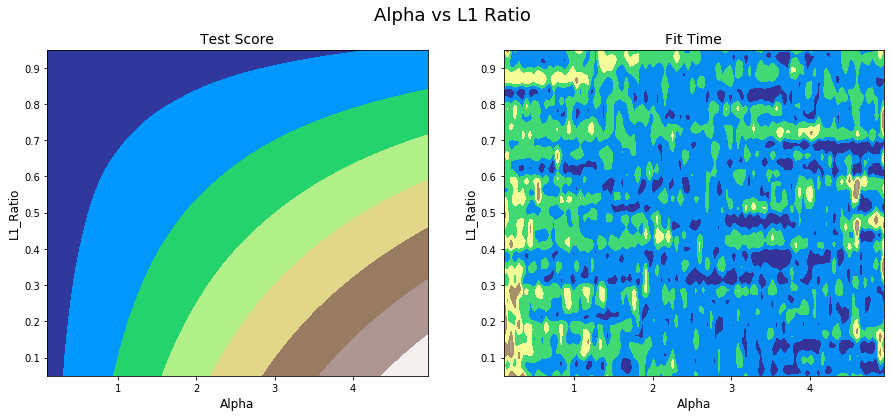

In [20]:
hyp.plot_two_hyperparms(res[(res.param_net__selection=='cyclic') & 
                            (res.param_net__positive==False)], 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

In this case, we see that both `precompute` and `selection` do not play a relevant role in improving the speed of the model. This time, we see that `alpha` can help the model in its predictions. In fact, in this case the target is generated by using only a few features and thus ignoring the useless ones is improving the model. We also see that `tol` can have some influence on the model performance but it is definitely `alpha` the hyperparameter to tune.


# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [9]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.1, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.1, 'l1_ratio': 0.95}

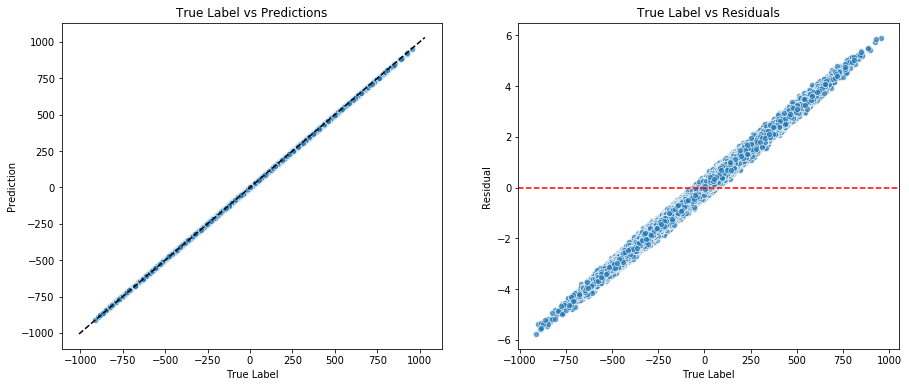

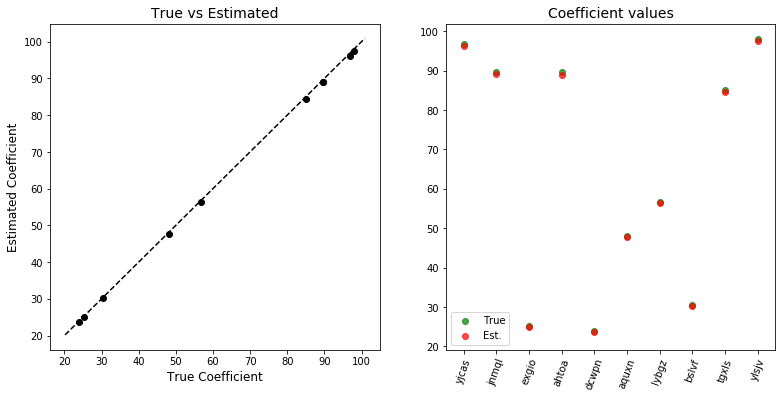

MAE: 		 1.11055
MSE: 		 1.94064
Max Error: 	 5.91056
Expl Variance: 	 0.99996


In [10]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

COMMENT

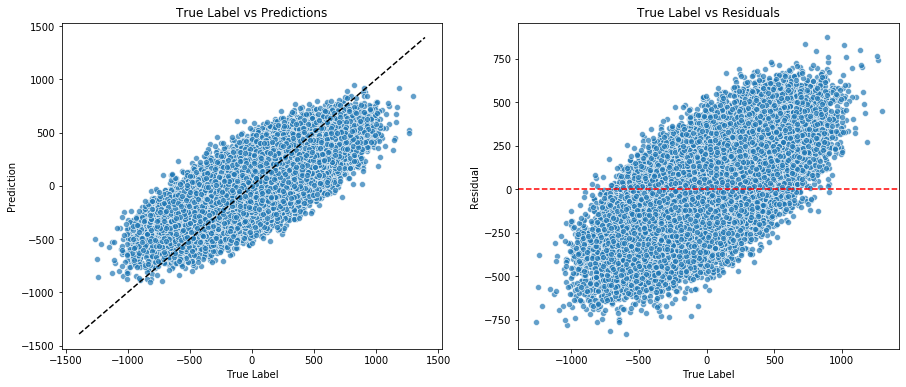

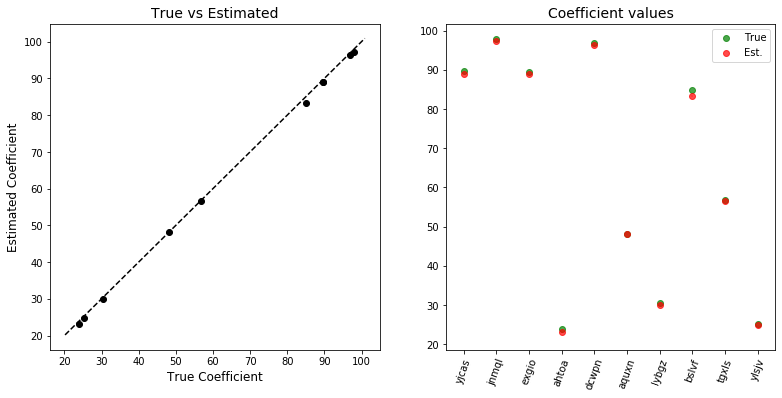

MAE: 		 159.16154
MSE: 		 39905.3432
Max Error: 	 870.85312
Expl Variance: 	 0.55335


In [11]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

COMMENT

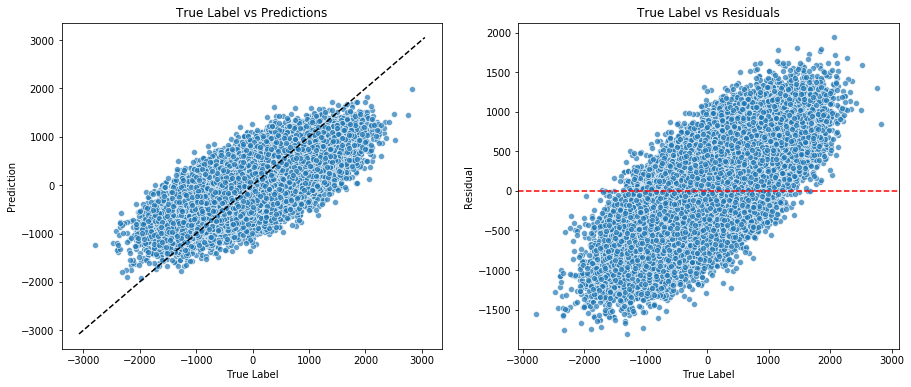

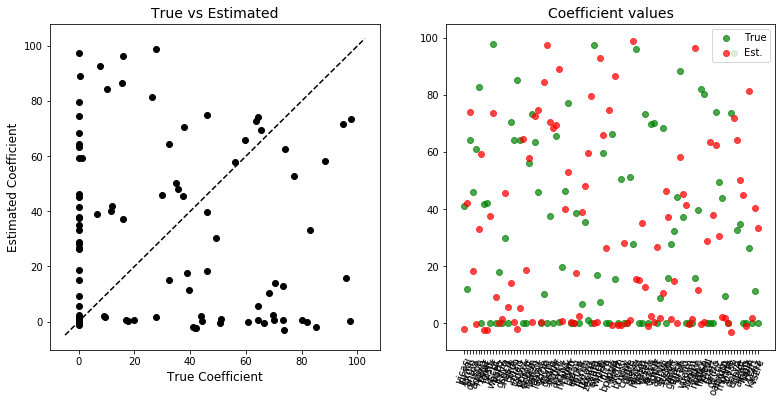

MAE: 		 359.51354
MSE: 		 202630.66287
Max Error: 	 1939.70904
Expl Variance: 	 0.48908


In [14]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.1, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.1, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We did not cure entirely the fact that the model sets to 0 many non-zero coefficients but we can at least see a small improvement in performance.

The same cannot be said if we also introduce some correlation between features.

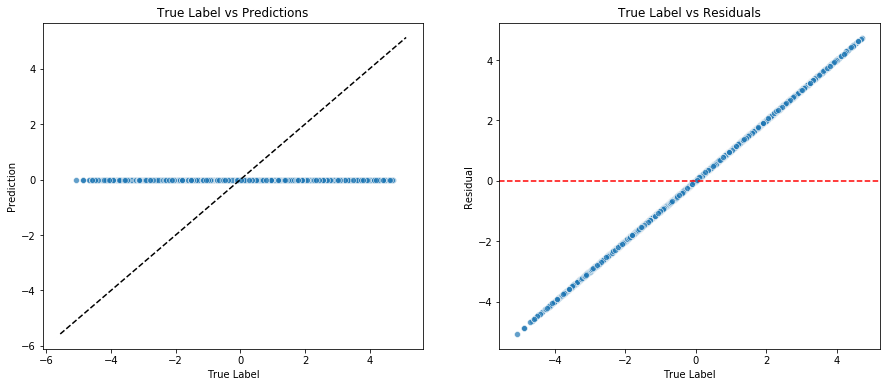

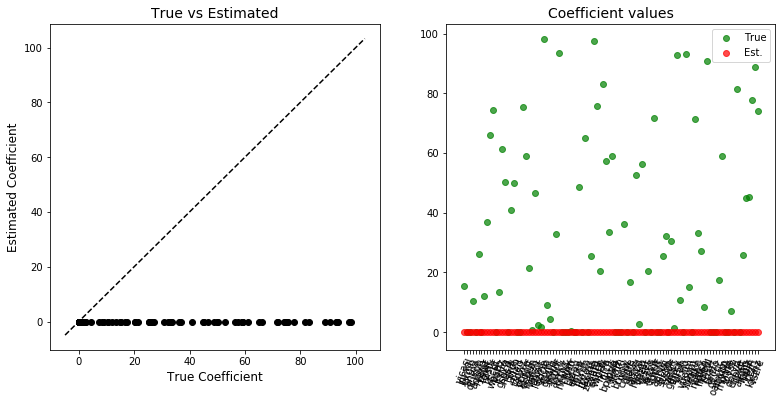

MAE: 		 0.93297
MSE: 		 1.36511
Max Error: 	 5.06419
Expl Variance: 	 -1e-05


In [16]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.1, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.1, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As the model is predicting nothing but 0's.

# Number of instances

The behavior is not changing much when we introduce the regularization. However, as in the case of `Ridge` the implementation is much more optimized and thus we get a better performance in terms of speed.

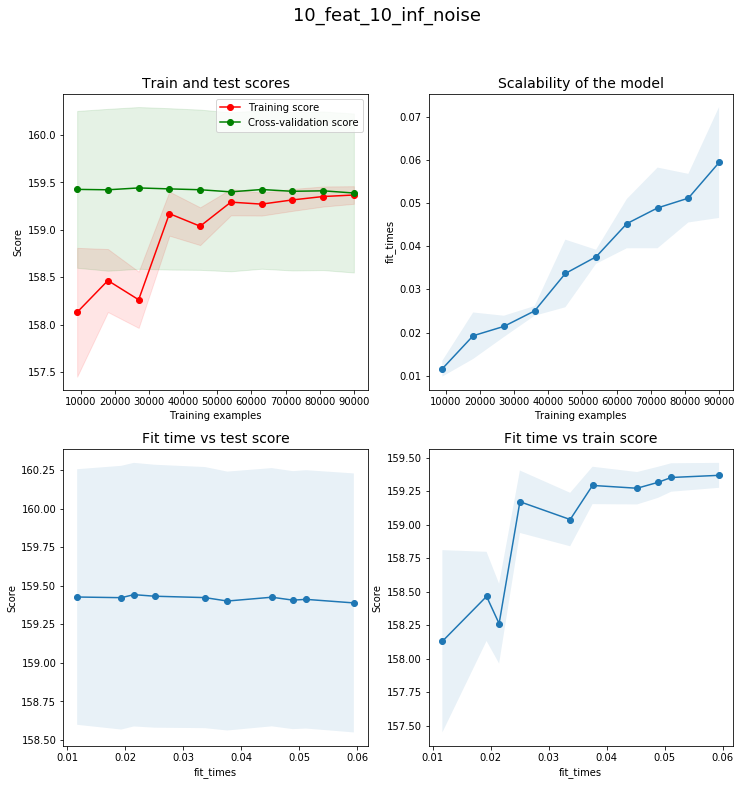

In [22]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=325))])

params = {'alpha': 0.1, 'l1_ratio': 0.5}

learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds without the regularization, while now it is around 0.55 seconds.

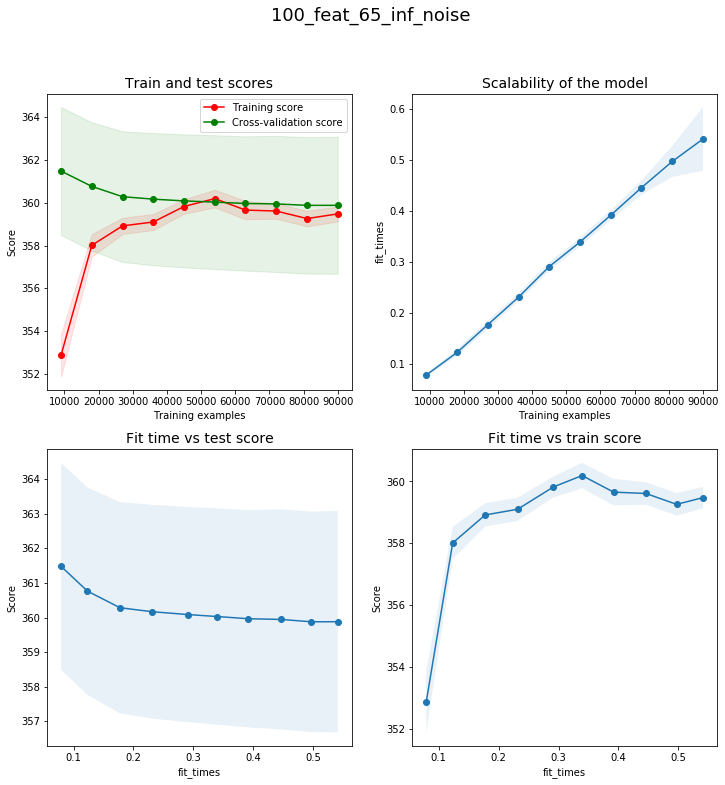

In [23]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

In the previous notebook we said that, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`. For numerical reasons, it is not adviced to do the same with `Lasso(alpha=0)`.

By reducing the number of training instances, we observe a less accurate set of predictions and the same underestimation of the coefficients.

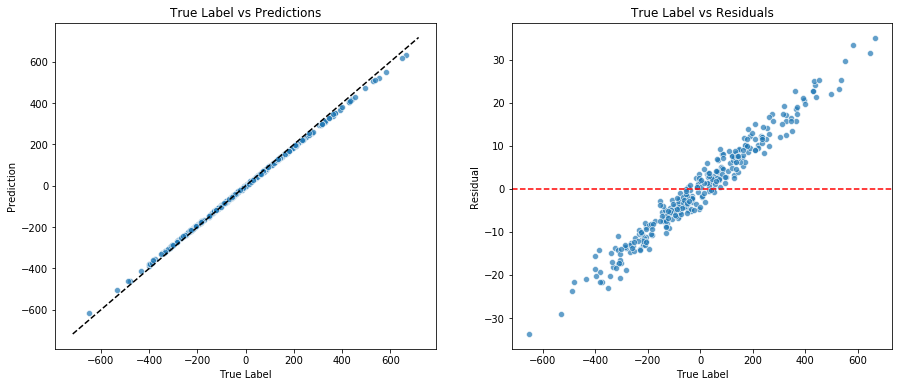

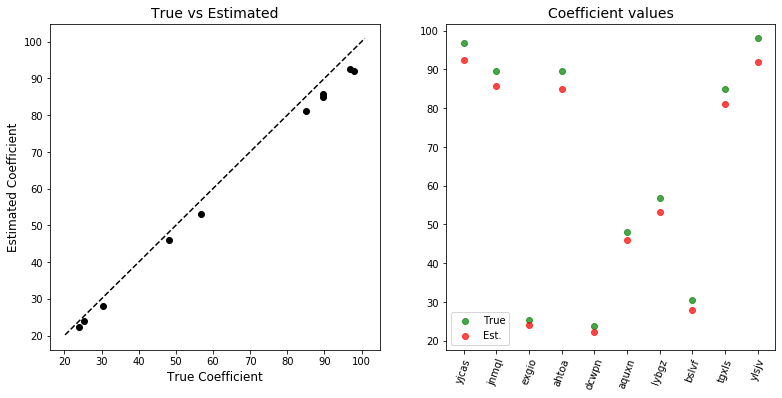

MAE: 		 9.06135
MSE: 		 131.13193
Max Error: 	 35.10792
Expl Variance: 	 0.99732


In [24]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

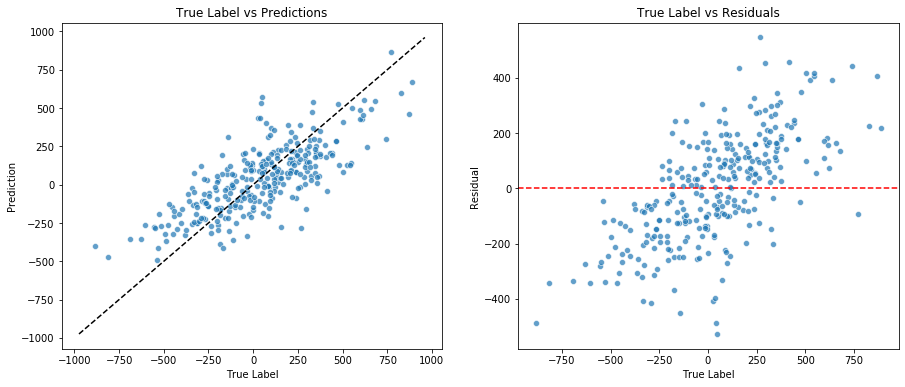

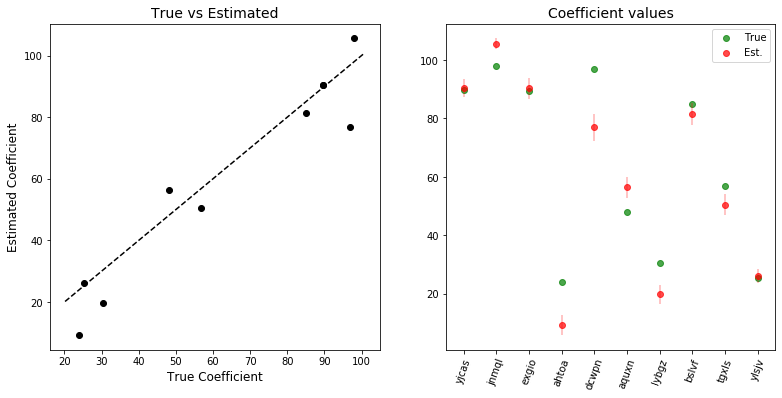

MAE: 		 159.49554
MSE: 		 38077.13672
Max Error: 	 545.60728
Expl Variance: 	 0.57661


In [25]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations.

## 100 features

As in the previous examples, the speed of the model is much higher (thanks to the better implementation) and we can again observe that the regularizing term is not influencing the ability of the model to be close to the best achievable result already with 9000 training samples.

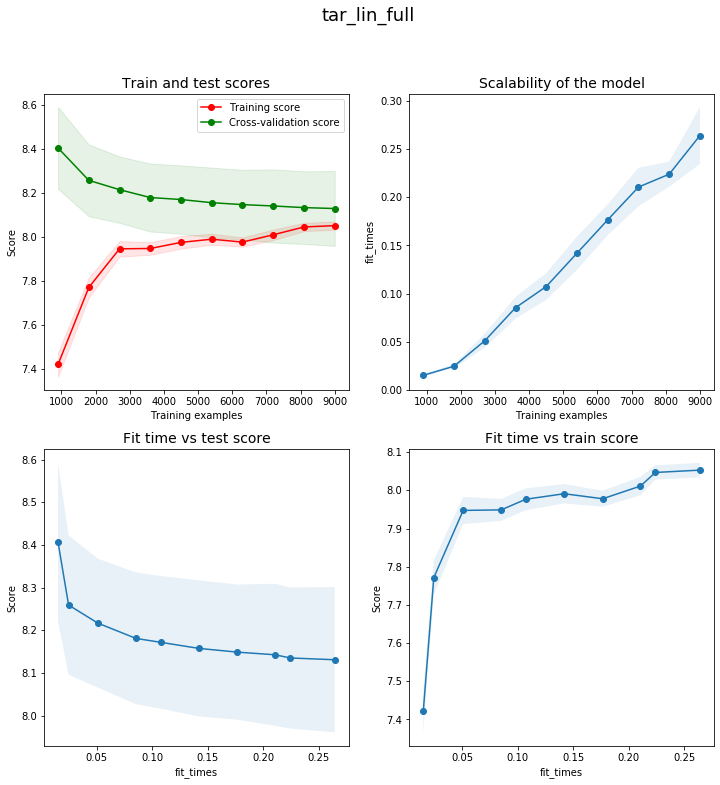

In [26]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

When using all the features, we can see how the model is setting to 0 several coefficients, regardless of their magnitude

{'net__alpha': 0.02, 'net__l1_ratio': 0.05}


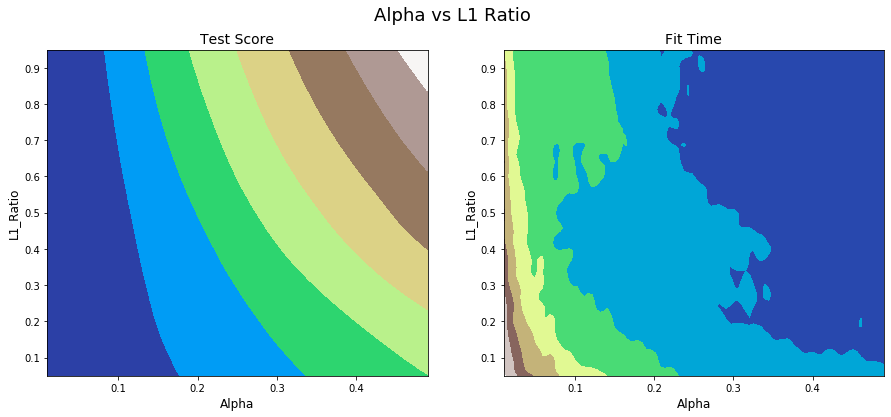

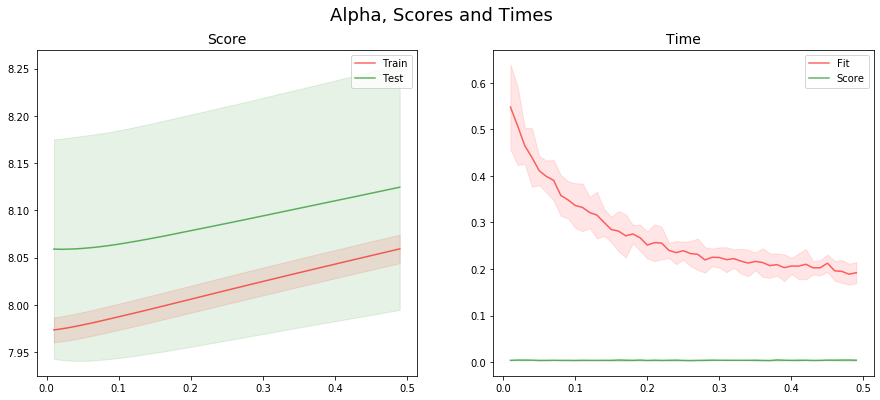

In [33]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.01, 0.5, 0.01)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', sample=10000)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

hyp.plot_hyperparameter(res[res.param_net__l1_ratio==0.05], 'param_net__alpha', 'Alpha')

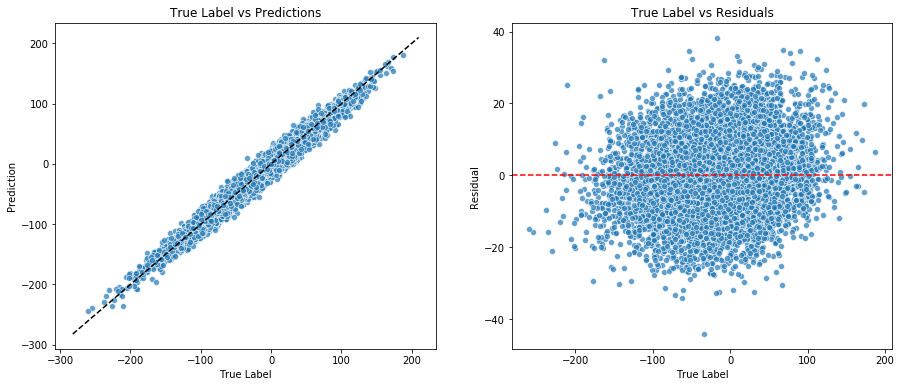

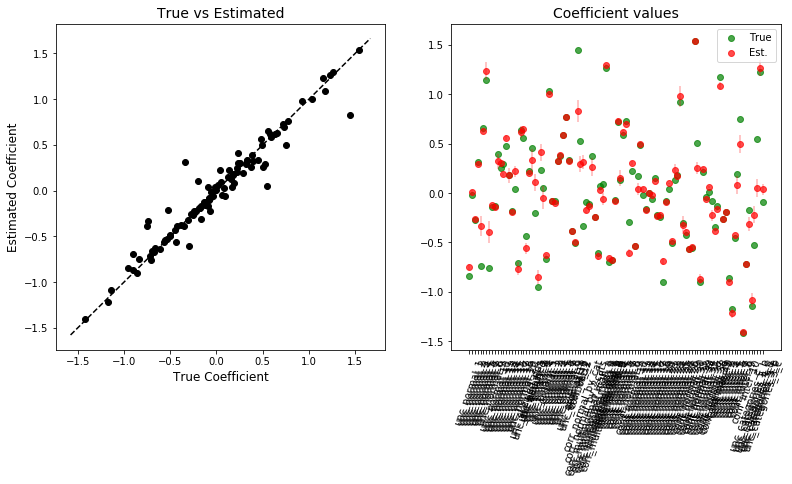

MAE: 		 8.12181
MSE: 		 103.07522
Max Error: 	 44.15246
Expl Variance: 	 0.96893


In [34]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.02, l1_ratio=0.05, random_state=325))])

params = {'alpha': 0.02, 'l1_ratio': 0.05}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As a consequence, the model is performing worse than before.

On the other hand, when reducing the number of training instances the drop in performance is much smaller than before.

{'net__alpha': 2.3, 'net__l1_ratio': 0.05}


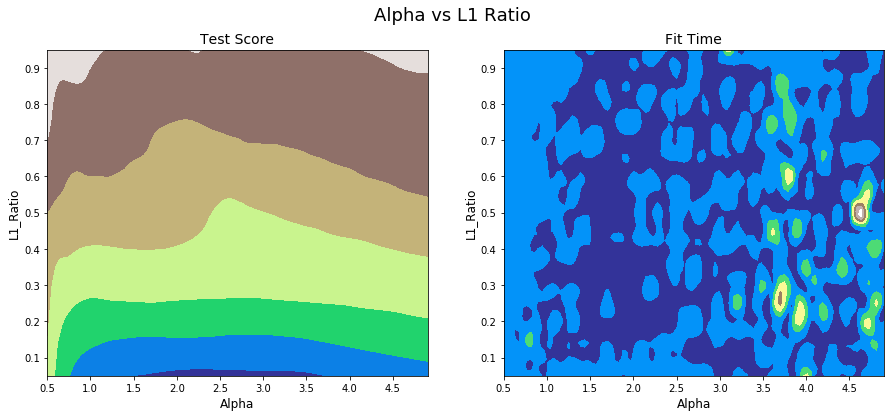

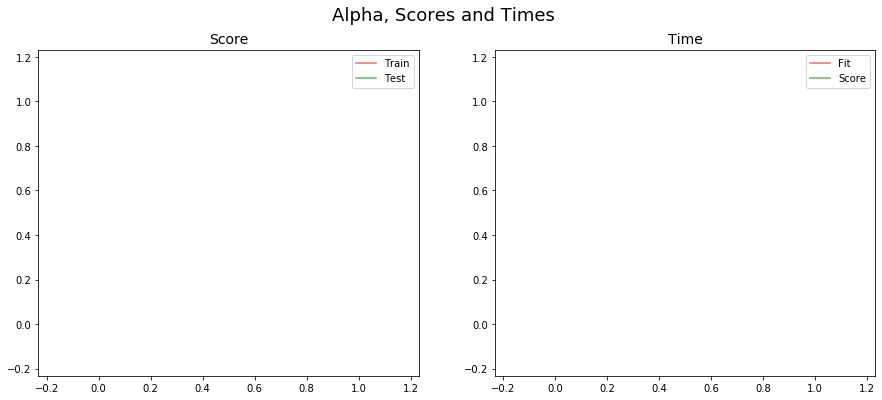

In [46]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.5, 5, 0.1)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', sample=100)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

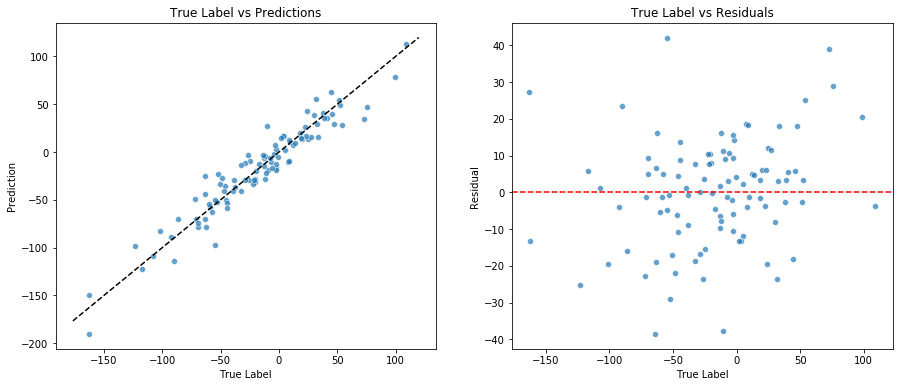

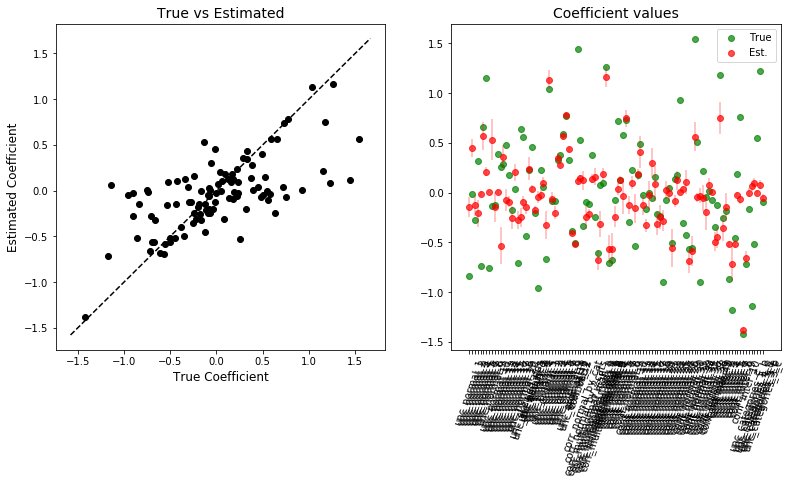

MAE: 		 11.25891
MSE: 		 214.53797
Max Error: 	 42.10409
Expl Variance: 	 0.91304


In [49]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=2.3, l1_ratio=0.05, random_state=325))])

params = {'alpha': 2.3, 'l1_ratio': 0.05}


make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This suggests that **the regularization is somewhat helping** and we indeed see that increasing it leads to a better performing model. This can be seen in the following plot.

In the presence of **unobserved variables**, however, the model struggles but not significantly more than before.

{'net__alpha': 0.08, 'net__l1_ratio': 0.05}


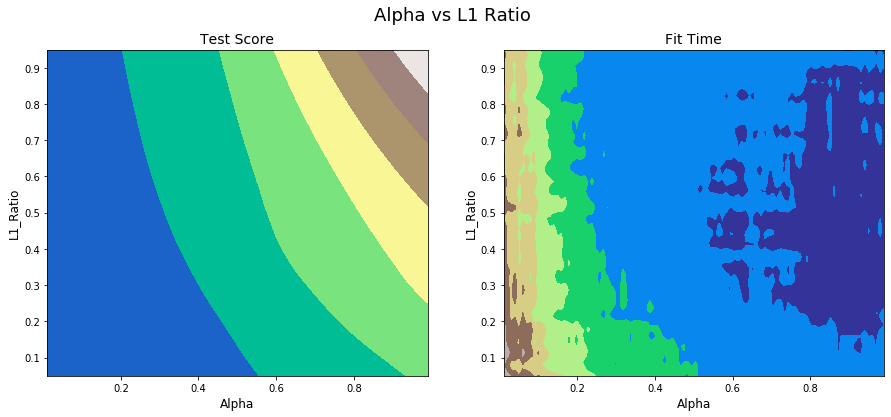

In [51]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.01, 0.5, 0.01)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', features='unobserved', sample=10000)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

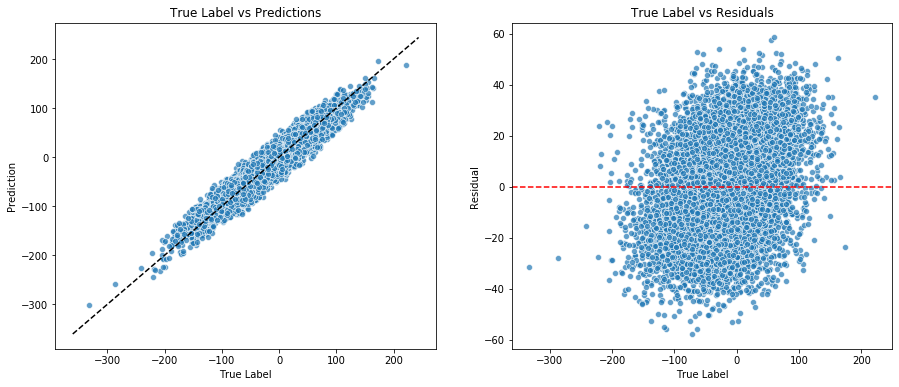

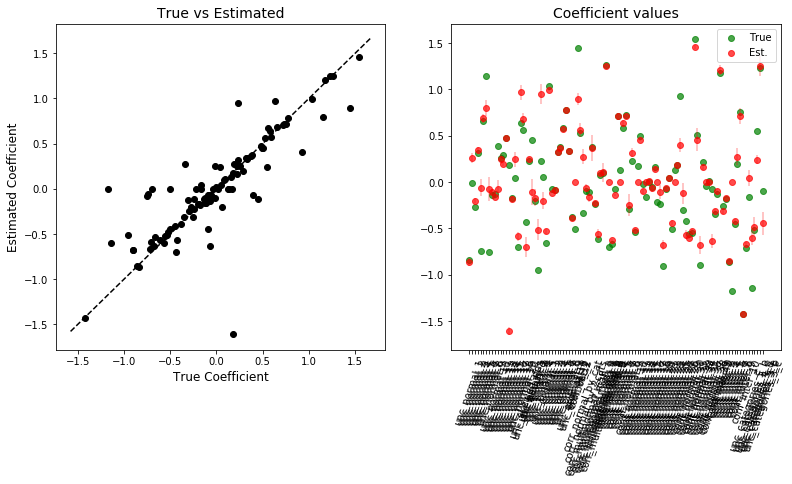

MAE: 		 15.64569
MSE: 		 357.93197
Max Error: 	 58.60037
Expl Variance: 	 0.89172


In [53]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.08, l1_ratio=0.05, random_state=325))])

params = {'alpha': 0.08, 'l1_ratio': 0.05}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 50 features

Let's now turn our attention to a situation where only 50 features of the 100 available have been used to generate the target

In [54]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=325))])

params = {'alpha': 0.5, 'l1_ratio': 0.5}

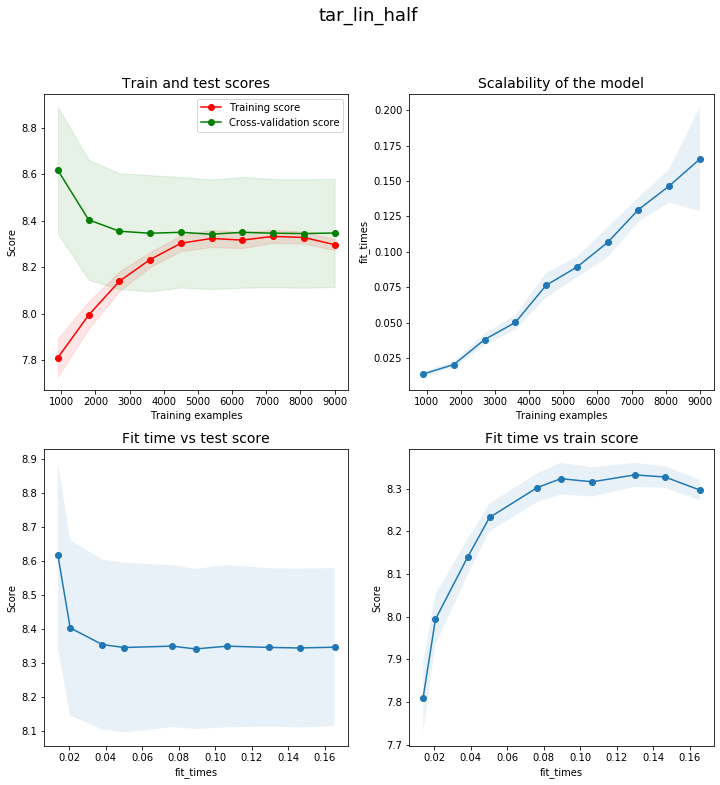

In [55]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

We can again appreciate how faster and more accurate the model becomes when we use the exact features we need to predict the target (remember that it roughly scales with the square of the number of features). Moreover, the model is now showing a more standard learning curve.

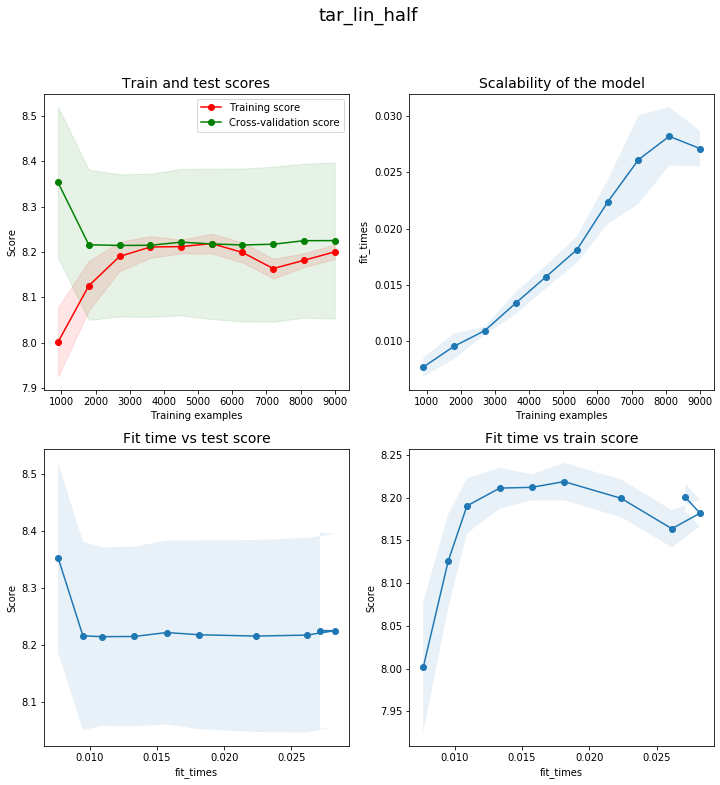

In [56]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We can thus use this as baseline for the next set of experiments. The performance is nearly identical with or without the regularization

{'net__alpha': 0.016, 'net__l1_ratio': 0.9500000000000001}


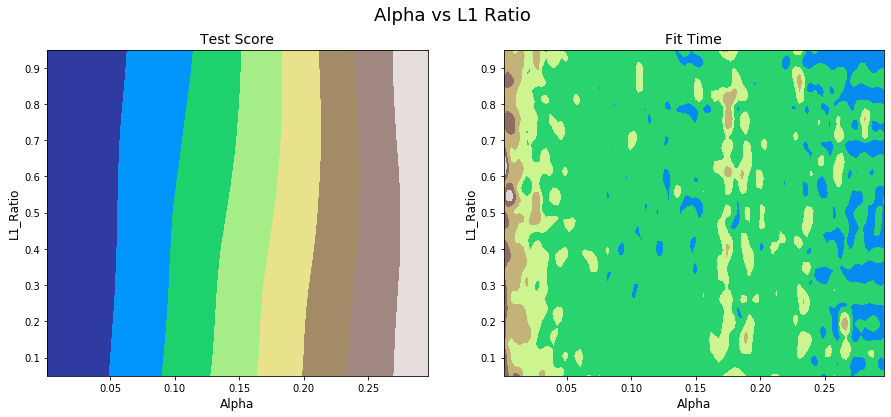

In [60]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.001, 0.3, 0.005)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', features='exact', sample=10000)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

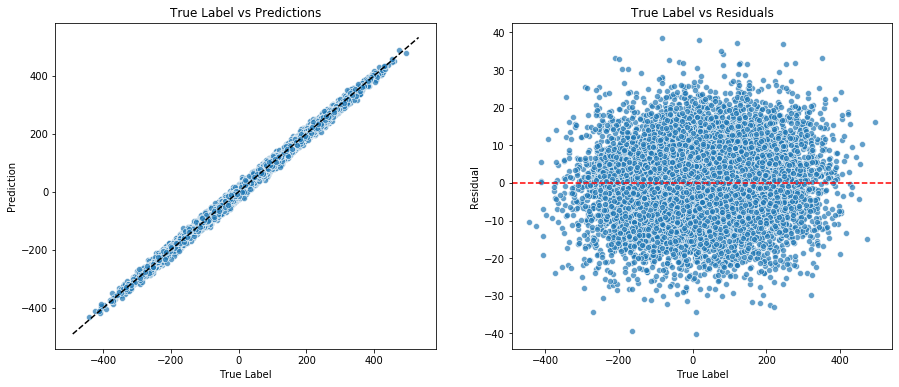

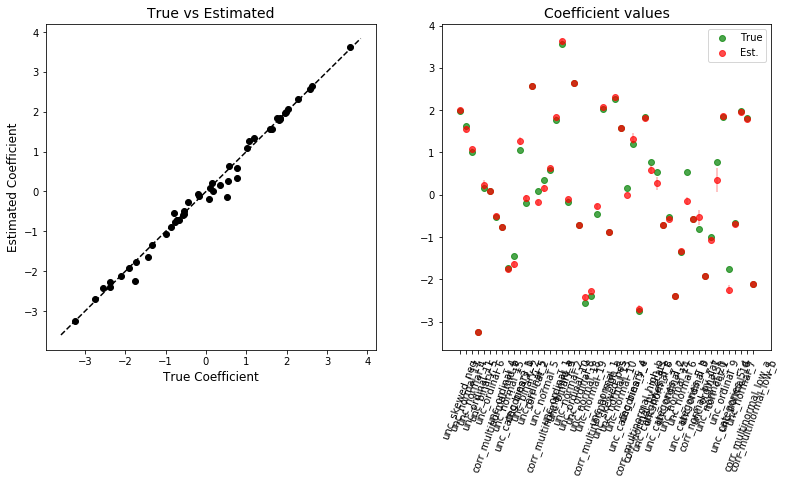

MAE: 		 7.9501
MSE: 		 100.14902
Max Error: 	 40.13237
Expl Variance: 	 0.9954


In [61]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.016, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.016, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Predictably, reducing the number of training instances leads to a worse performing model but, this time, it is performing better than its non-regularized counterpart

{'net__alpha': 0.426, 'net__l1_ratio': 0.9500000000000001}


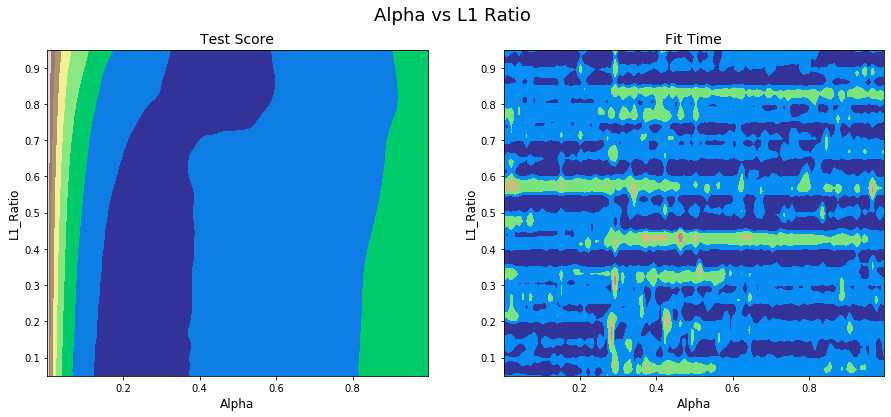

In [66]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(0.001, 1, 0.005)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', features='exact', sample=100)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

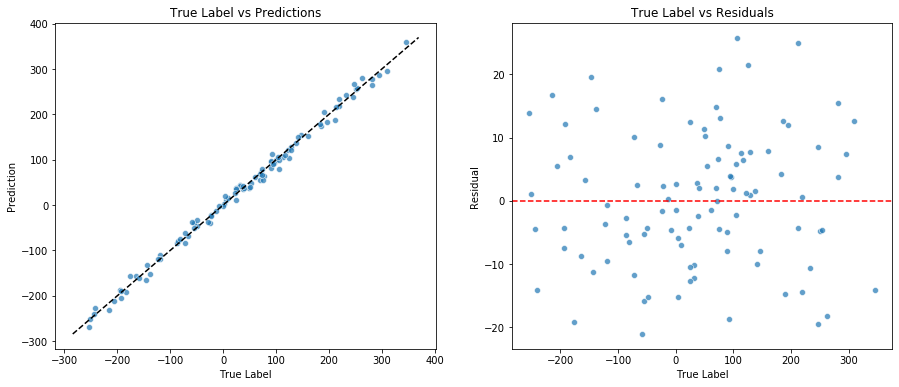

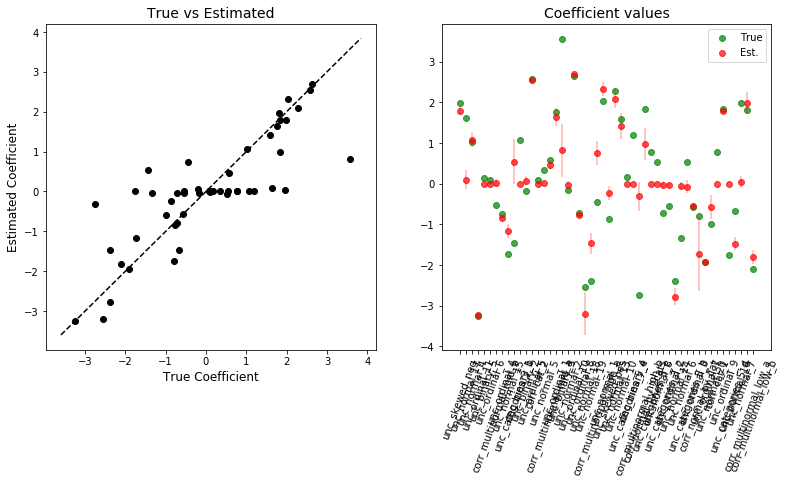

MAE: 		 8.68066
MSE: 		 112.39836
Max Error: 	 25.82359
Expl Variance: 	 0.9946


In [67]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.426, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.426, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Training the model on more features than necessary doesn't seem to influence the performance or the coefficients' estimates much (meaning that the estimate is still fairly poor).

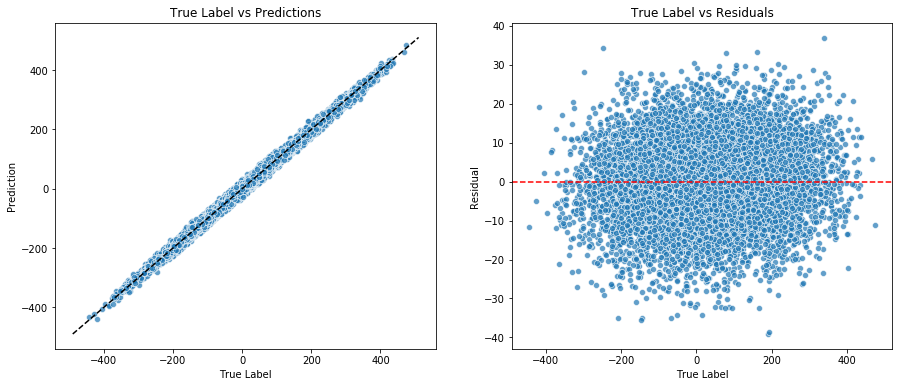

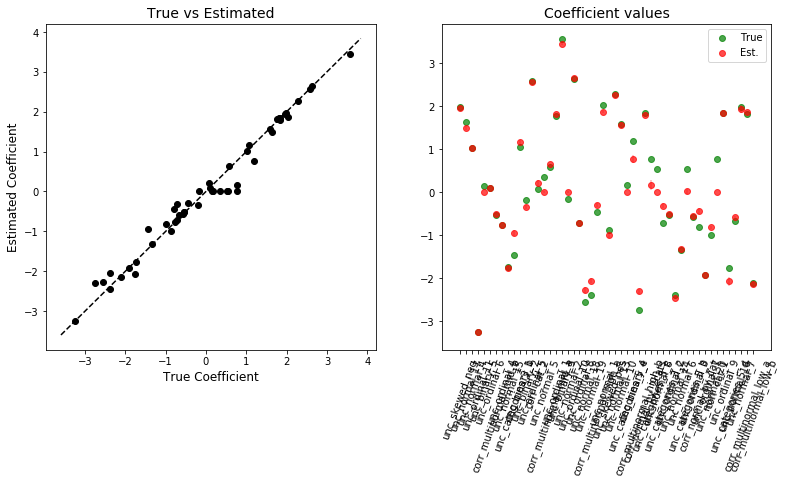

MAE: 		 8.09337
MSE: 		 102.70896
Max Error: 	 39.1064
Expl Variance: 	 0.99533


In [69]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=0.031, l1_ratio=0.95, random_state=325))])

params = {'alpha': 0.031, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

The role of the optimization can be observed again when we have to work with a limited amount of observations. Indeed, the regularization will set to 0 coefficients that are not relevant and thus control the overfitting of the model on this limited dataset.

{'net__alpha': 2.4000000000000012, 'net__l1_ratio': 0.9500000000000001}


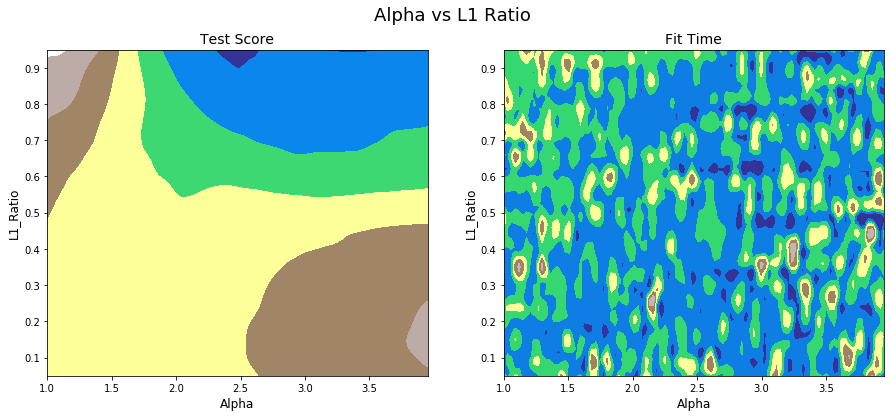

In [71]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(random_state=325))])

param_grid = {'net__alpha': list(np.arange(1, 4, 0.05)), 
              'net__l1_ratio': np.arange(0.05, 1, 0.05)}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', features='all', sample=100)

hyp.plot_two_hyperparms(res, 'param_net__alpha', 'param_net__l1_ratio', 'Alpha vs L1 Ratio')

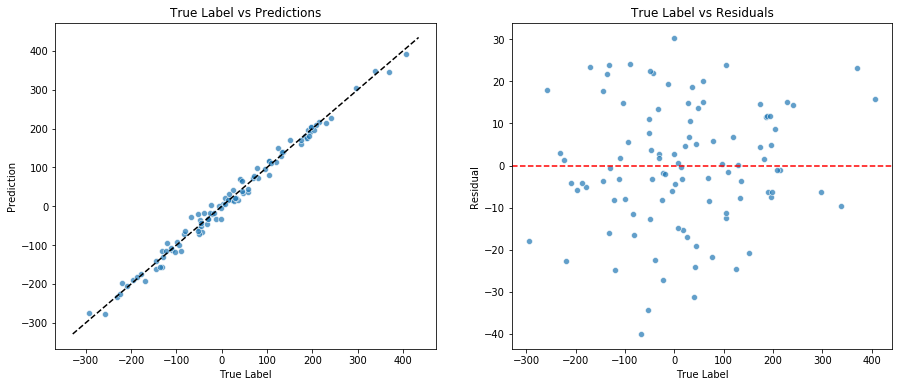

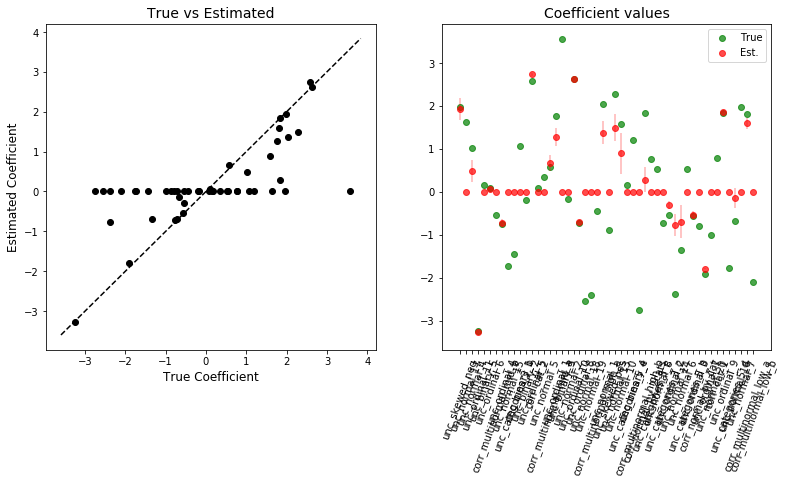

MAE: 		 11.70258
MSE: 		 215.44231
Max Error: 	 40.00032
Expl Variance: 	 0.98924


In [72]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('net', ElasticNet(alpha=2.4, l1_ratio=0.95, random_state=325))])

params = {'alpha': 2.4, 'l1_ratio': 0.95}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We see indeed how a model with regularization is outperforming its unregularized counterpart.

On the other hand, when it is a certain number of features missing, the regularization does not seem to help much.

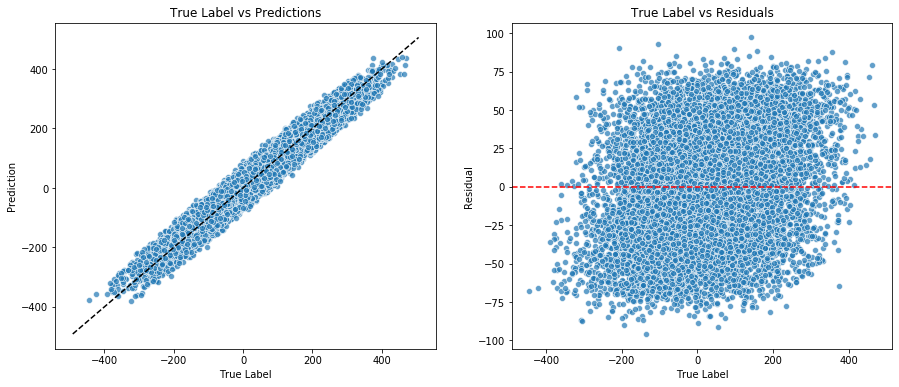

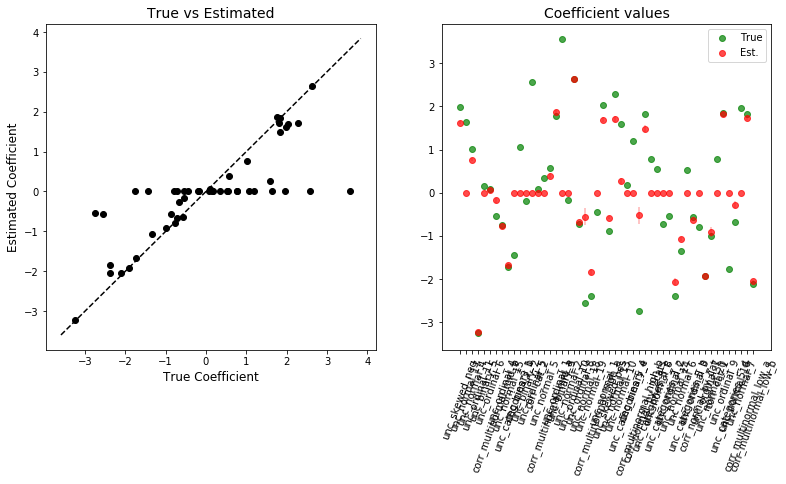

MAE: 		 32.47773
MSE: 		 1446.55142
Max Error: 	 97.25234
Expl Variance: 	 0.93387


In [40]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

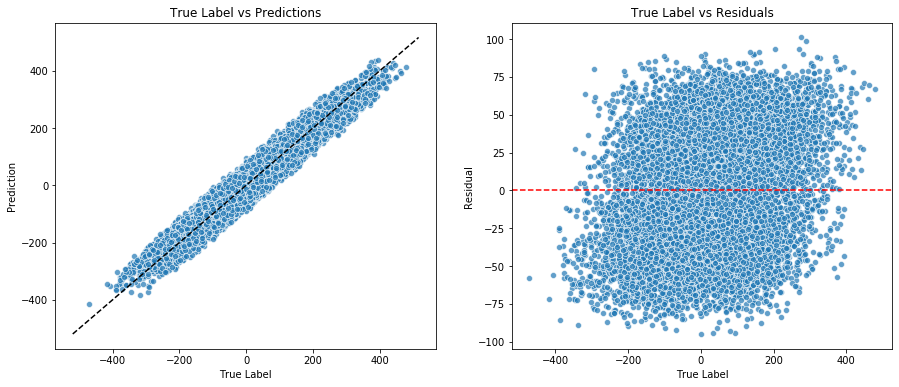

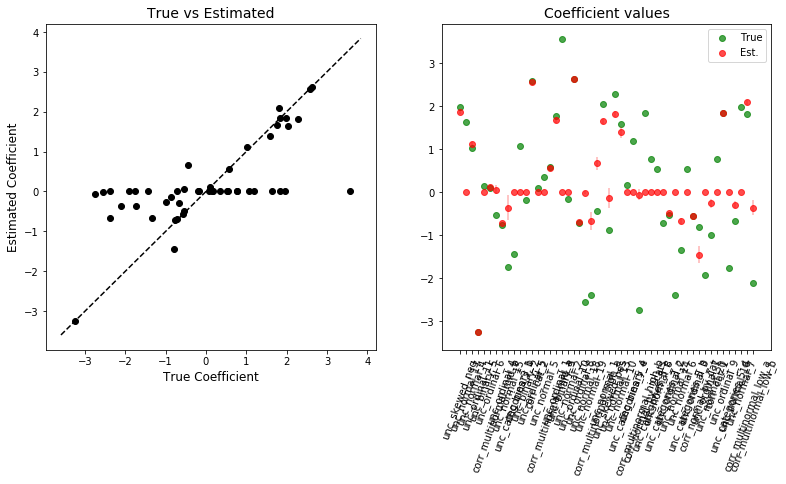

MAE: 		 34.37007
MSE: 		 1617.61769
Max Error: 	 101.03318
Expl Variance: 	 0.92634


In [41]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 10 features

With a low number of features, the Lasso regularization tends to put too many coefficients to 0, resulting in a model that performs worse than its unregularized counterpart (and of the $L_2$ regularized version)

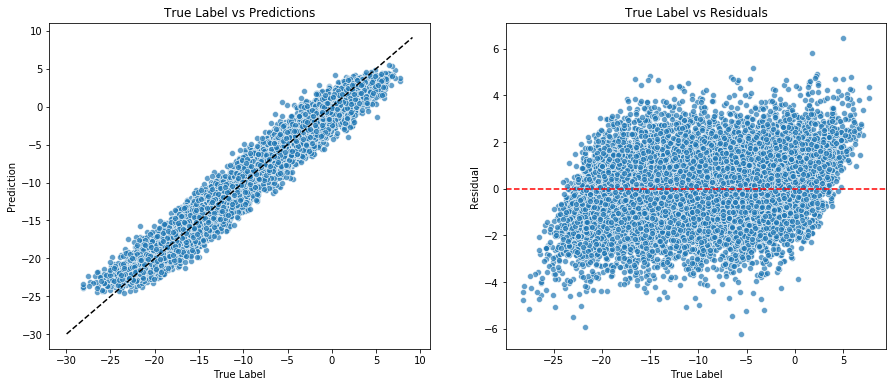

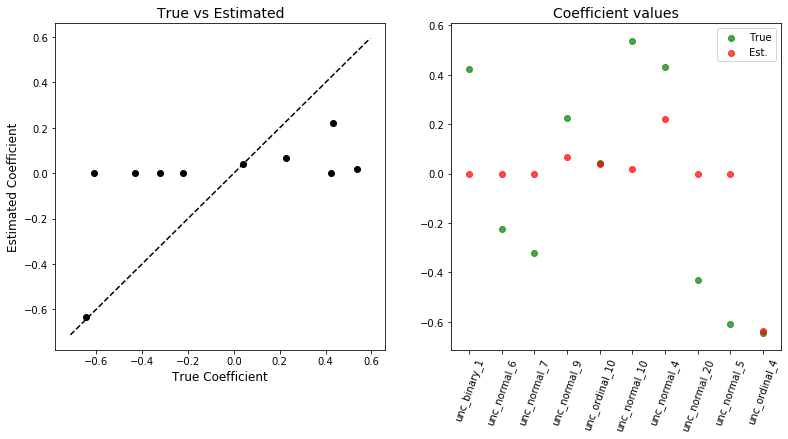

MAE: 		 1.2507
MSE: 		 2.45226
Max Error: 	 6.46691
Expl Variance: 	 0.95727


In [42]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We even get a better performance by reducing the number of observations, a result that challenge our intuition quite considerably.

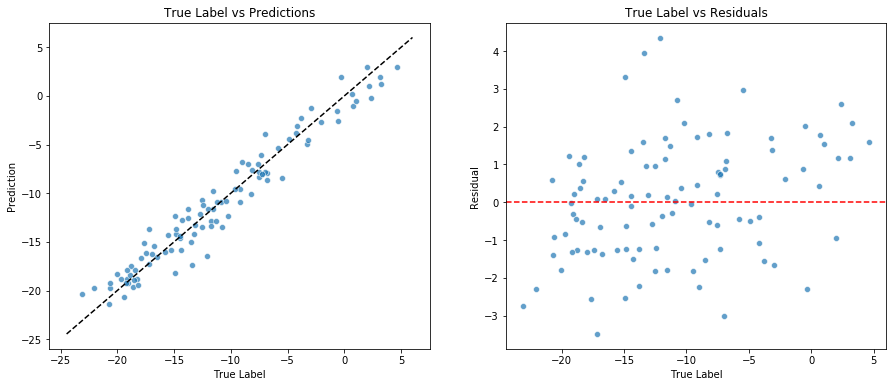

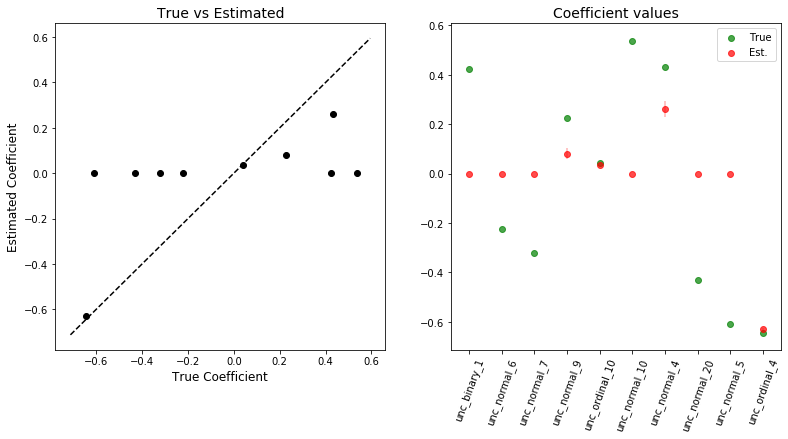

MAE: 		 1.2604
MSE: 		 2.39902
Max Error: 	 4.35174
Expl Variance: 	 0.94746


In [43]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This poor perfomance seems to be unaffected by the presence of truly useless variables.

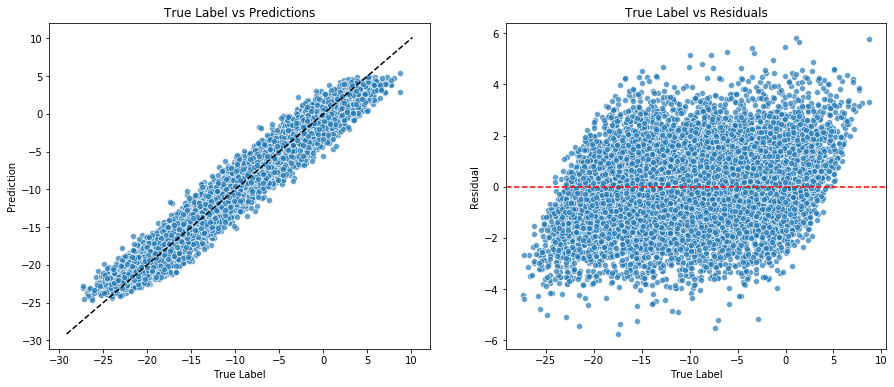

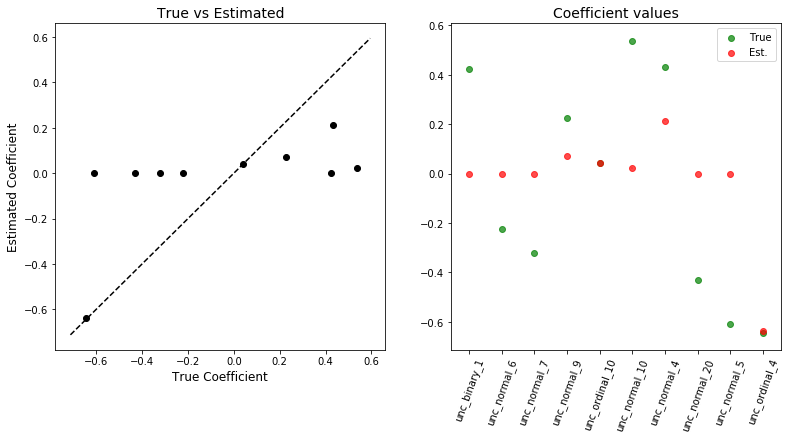

MAE: 		 1.2396
MSE: 		 2.42438
Max Error: 	 5.83033
Expl Variance: 	 0.95751


In [44]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

But for sure it is noticeable when some important feature is missing.

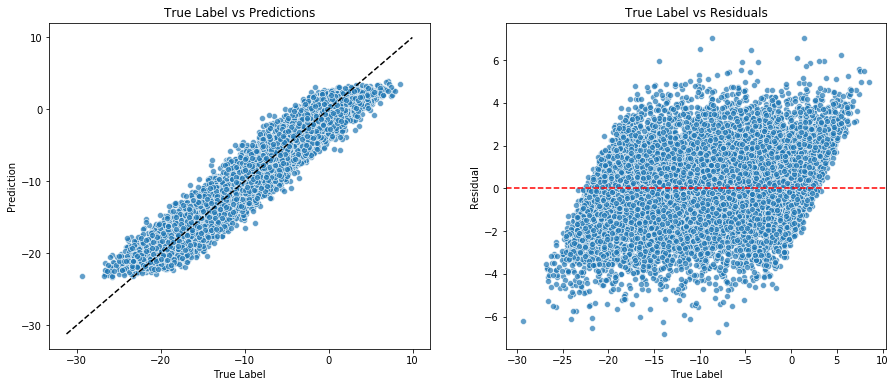

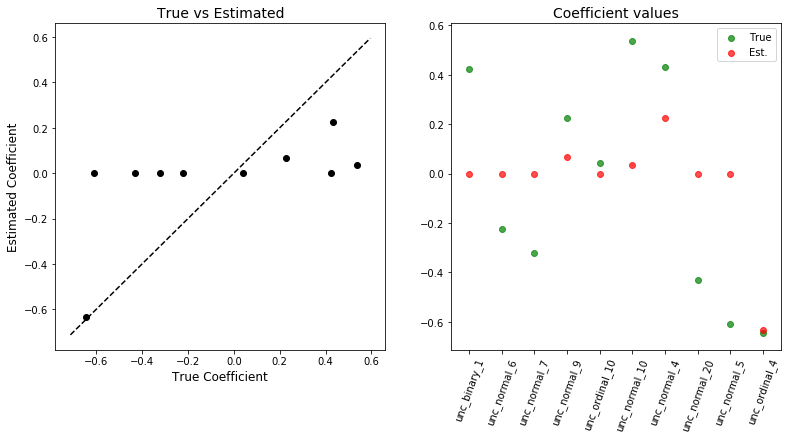

MAE: 		 1.56859
MSE: 		 3.79153
Max Error: 	 7.04414
Expl Variance: 	 0.93352


In [45]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

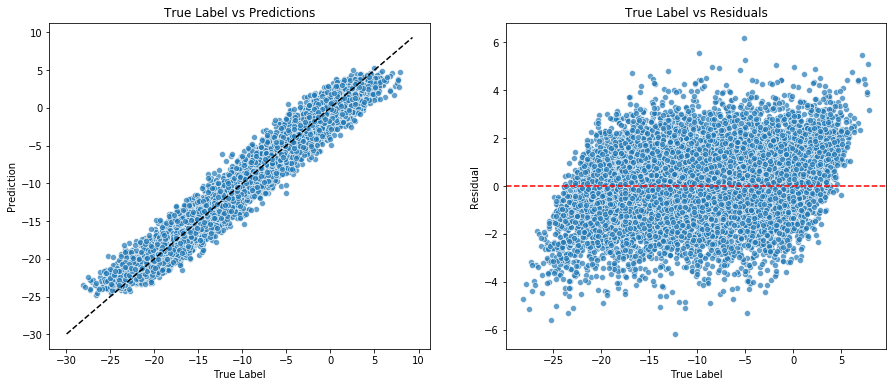

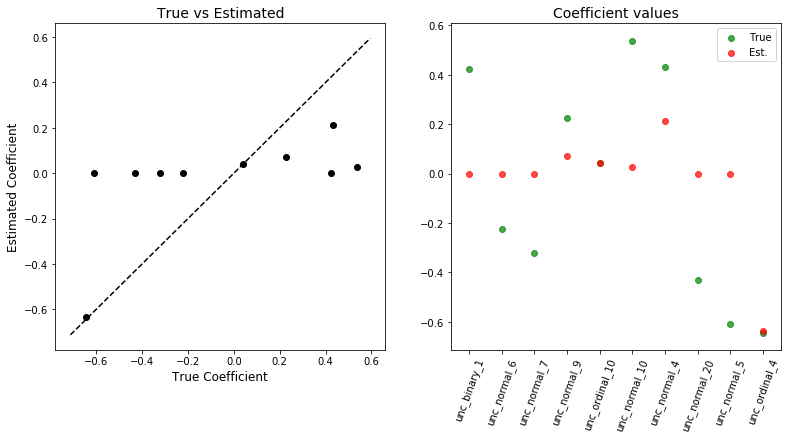

MAE: 		 1.23716
MSE: 		 2.41459
Max Error: 	 6.18489
Expl Variance: 	 0.95824


In [46]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## Non-linear relations

We have seen in notebook 4 that the regularization was helping the (already) surprisingly well-performing model even with a target generated by a non-linear relation.

In this case, we observe that the model needs fewer observation to reach its best performance.

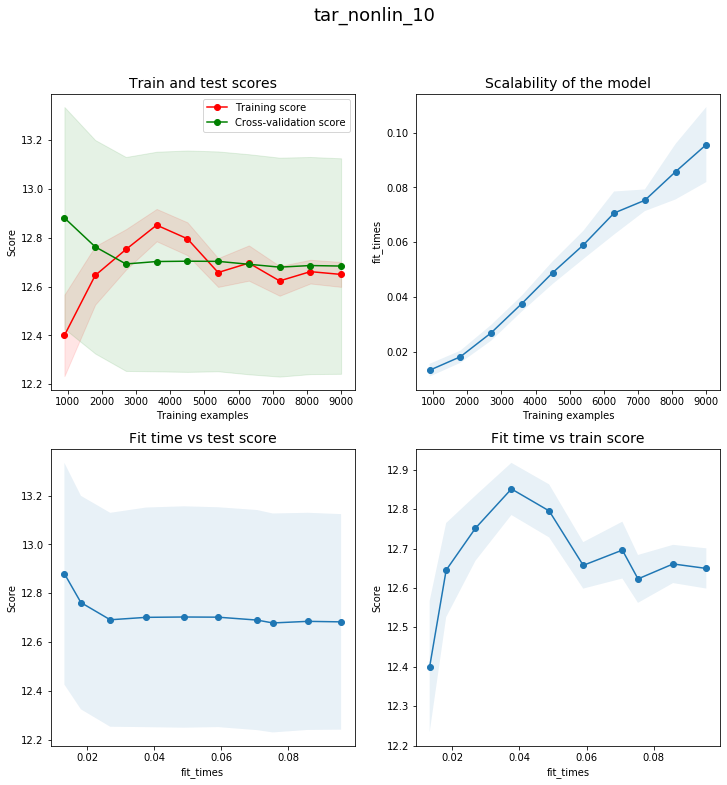

In [47]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

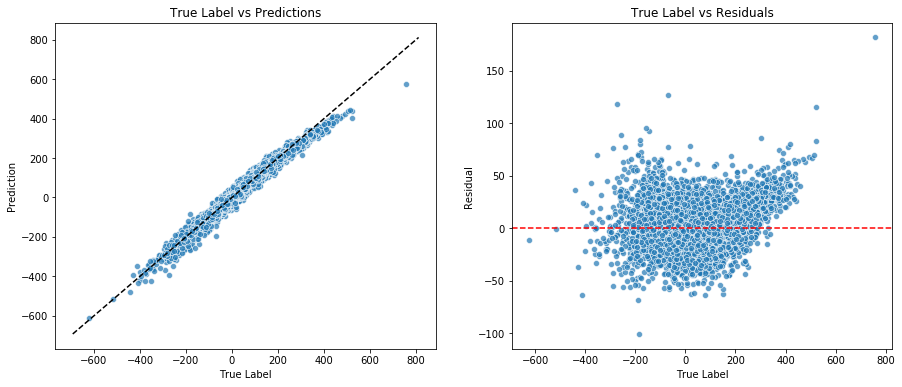

MAE: 		 12.68841
MSE: 		 296.87573
Max Error: 	 181.68921
Expl Variance: 	 0.97998


In [48]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

Once again, reducing the number of observations leads to a worse performance but, once again, it is this the situation where the regularization is helpful the most

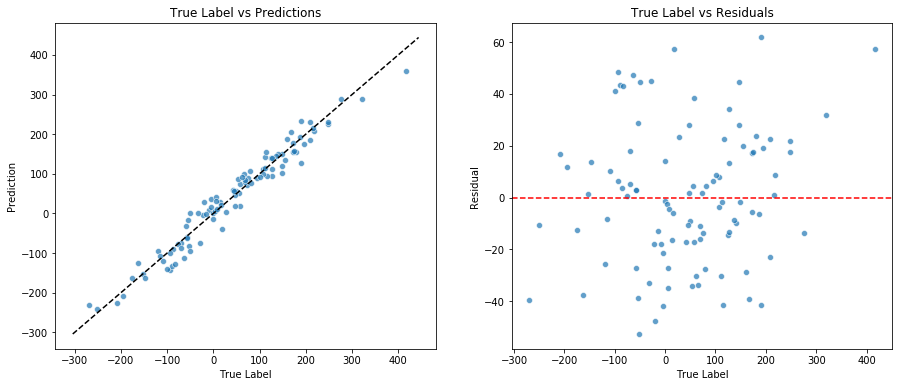

MAE: 		 21.34225
MSE: 		 695.12311
Max Error: 	 61.73721
Expl Variance: 	 0.95661


In [49]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

{'lasso__alpha': 3.7}


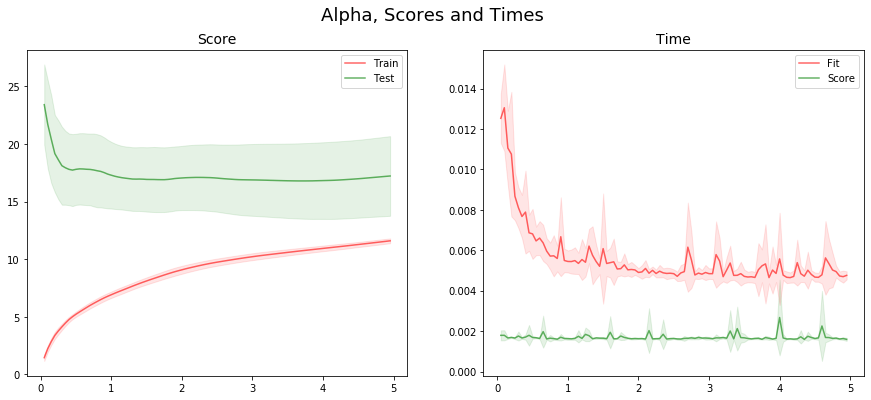

In [50]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

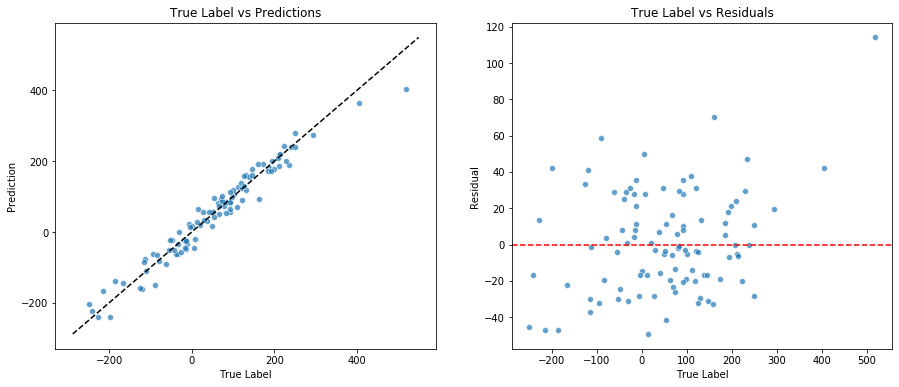

MAE: 		 22.18838
MSE: 		 791.22439
Max Error: 	 114.02231
Expl Variance: 	 0.95558


In [51]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2.5, random_state=325))])
params = {'alpha': 2.1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

# Real application - HousePrice

It is finally time to test the performance of this algorithm on the dataset of the House Price competition. As before, we use a generic pipeline [developed in this notebook](https://www.kaggle.com/lucabasa/houseprice-end-to-end-project). 

We expect to see more and more coefficients to be set to 0 as they refer to truly unimportant features.

First, let's see how the model is influenced by the choice of hyperparameters

In [52]:
model = ('lasso', Lasso())
params = {'alpha':1}

param_grid = {'lasso__alpha': list(np.arange(0.0001, 0.002, 0.0005)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False]}

res = grid_results(model, kfolds, param_grid, hp=True)

res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'lasso__alpha': 0.0006000000000000001, 'lasso__positive': False, 'lasso__selection': 'random', 'lasso__tol': 0.0005}


param_lasso__alpha param_lasso__positive param_lasso__selection  \
0             0.0006                 False                 random   
1             0.0006                 False                 cyclic   
2             0.0006                 False                 cyclic   
3             0.0006                 False                 cyclic   
4             0.0006                 False                 cyclic   

  param_lasso__tol  mean_train_score  std_train_score  mean_test_score  \
0           0.0005         -0.080697         0.000967        -0.083870   
1           0.0009         -0.080686         0.000974        -0.083873   
2           0.0008         -0.080687         0.000973        -0.083876   
3           0.0007         -0.080689         0.000973        -0.083878   
4           0.0006         -0.080690         0.000973        -0.083881   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.007971       0.174318      0.006717         0.104536   
1        0.007967       0.173769      0.012256         0.102931   
2        0.007966       0.181686      0.014685         0.106076   
3        0.007966       0.174751      0.008498         0.106428   
4        0.007966       0.176653      0.013241         0.101153   

   std_score_time  
0        0.006558  
1        0.005849  
2        0.008928  
3        0.009386  
4        0.004913

We first look at the hyperparameter that is not supposed to affect the performance but rather the execution time. We observe that the influence of this hyperparameter is much smaller than in the experiment above. It can both be because more realistic data makes this choice less relevant or because the limited amount of observations do not let us appreciate its effect.

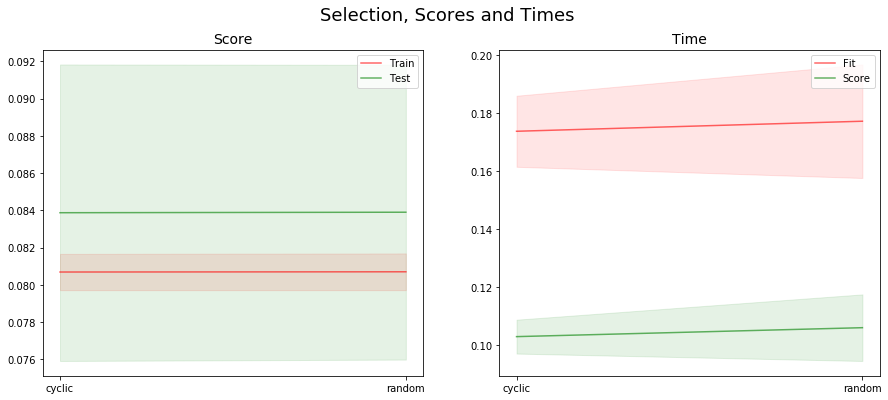

In [53]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.0006000000000000001) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False)], 'param_lasso__selection', 'Selection')

Forcing the coefficients to be positive means setting to 0 all the negative one and, as we know, we have features in the data that are supposed to give a negative contribution to the final house price. Thus, we observe that doing so makes the model faster (fewer features with non-zero coefficient) but worse in terms of perfomance.

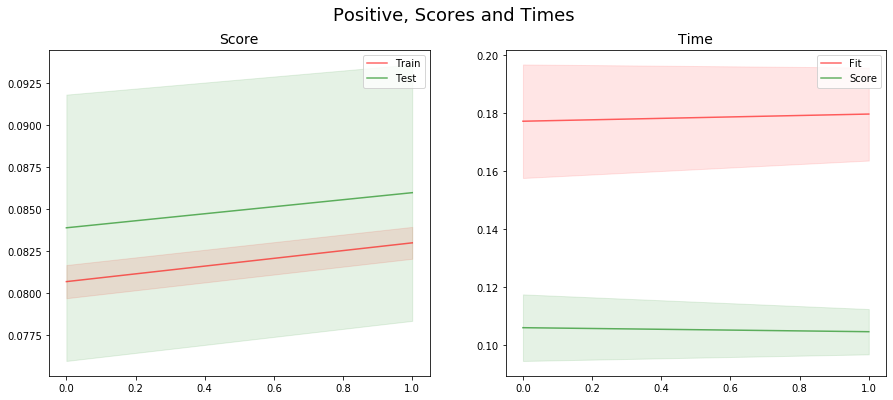

In [54]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.0006000000000000001) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__positive', 'Positive')

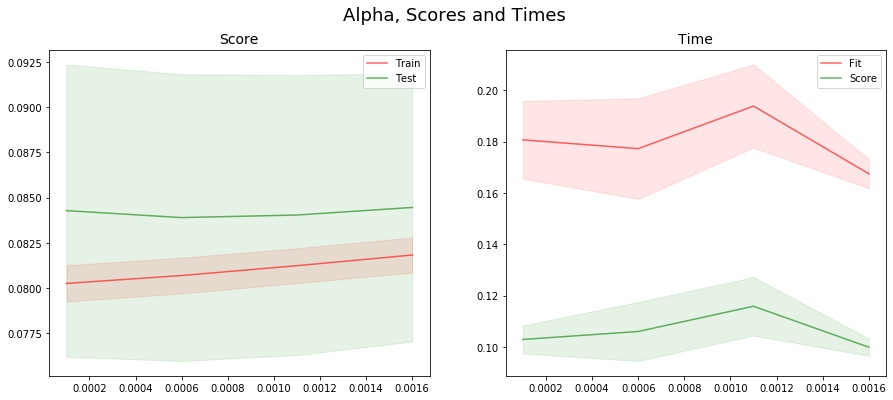

In [55]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'Alpha')

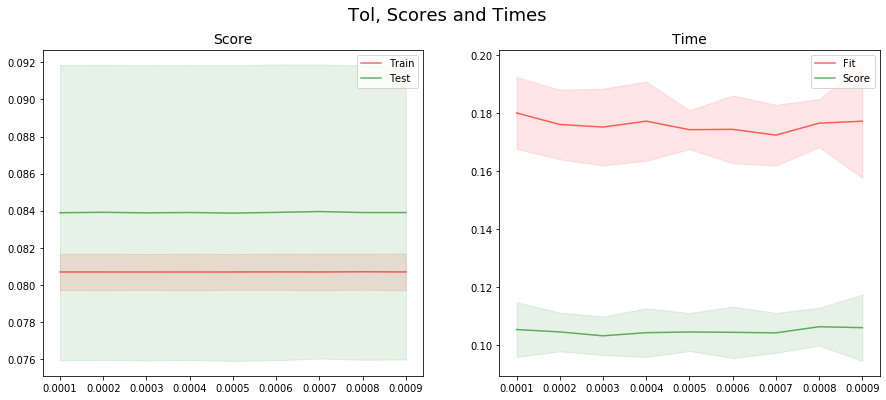

In [56]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__alpha==0.0006000000000000001) & 
                            (res.param_lasso__positive==False)], 'param_lasso__tol', 'Tol')

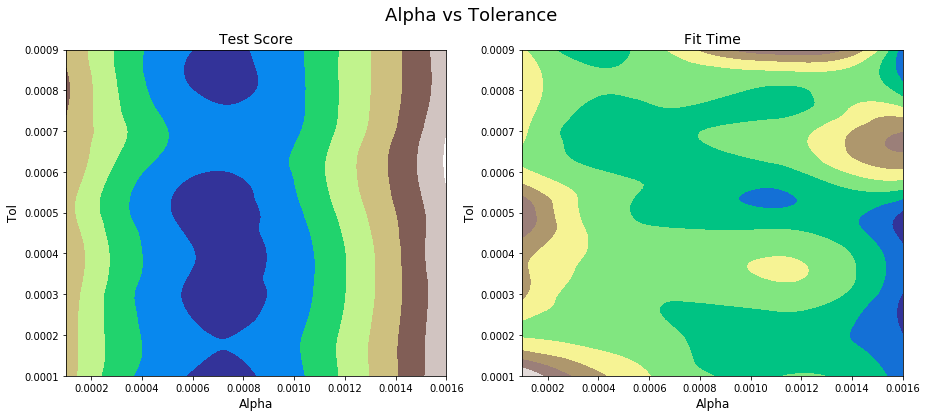

In [57]:
hyp.plot_two_hyperparms(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

We finally see some more interesting patterns, some regularization seems to help but it then stops being helpful. Moreover, at the sweet spot for the hyperparameter `alpha,` we see that playing around with `tol` can improve or worsen the performance of the model. On the other hand, once that `alpha` is away from this spot, this hyperparameter stops being relevant.

We indeed see that adding a small regularizing term leads to a model that not only performs slightly better (to be fair, it is an improvement at the third digit of each metric) but, most importantly, helps the model estimating the coefficients with less uncertainty.

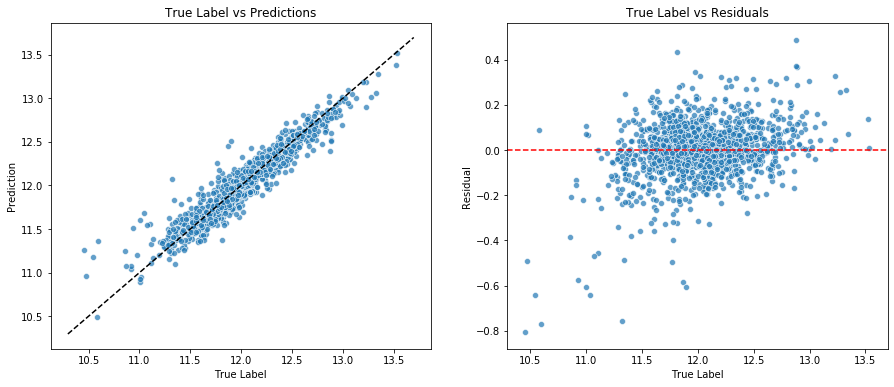

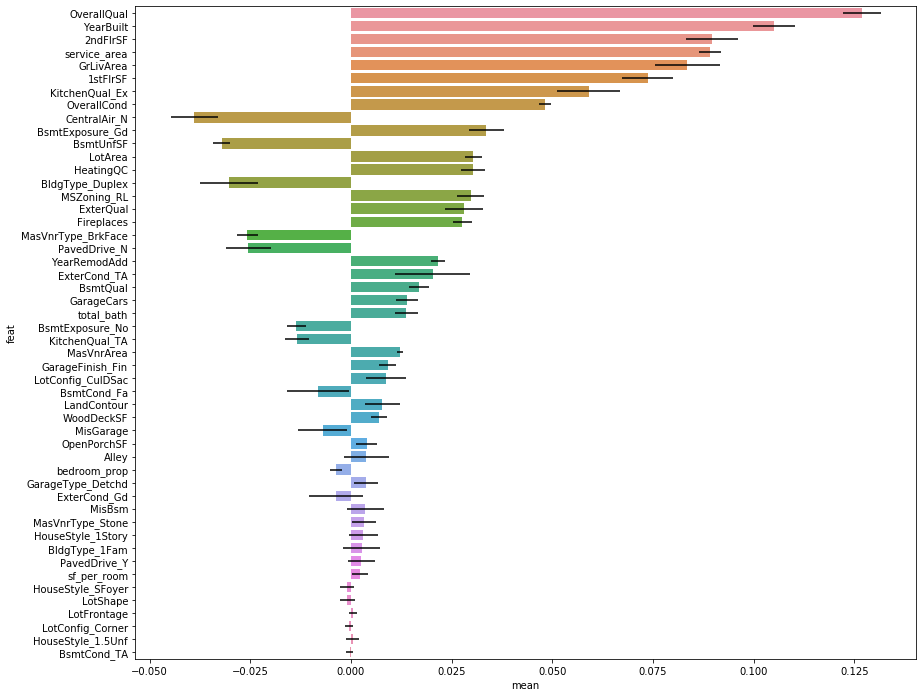

MAE: 		 0.08387
MSE: 		 0.01465
Max Error: 	 0.80369
Expl Variance: 	 0.90824


In [58]:
model = ('lasso', Lasso(alpha=0.0006, tol=0.0009))
params = {'alpha':0.0006, 'tol': 0.0009}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

We observe again the counterintuitive result for the coefficient of `ExterCond_Gd` but we also see how the model is not really sure about it.

If, for fun, we force the coefficients to be positive we get

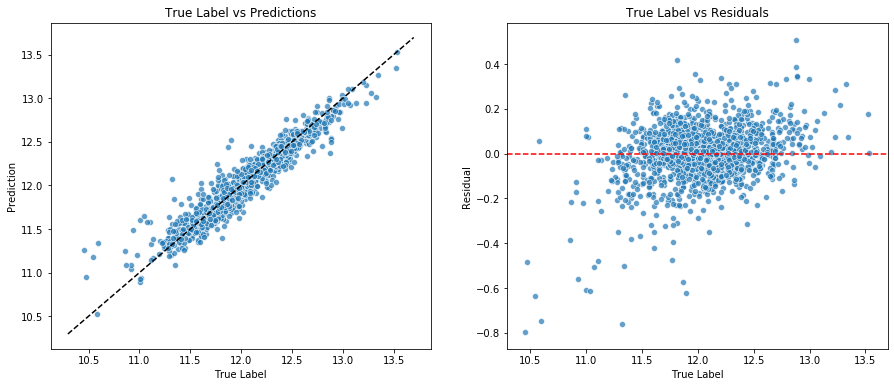

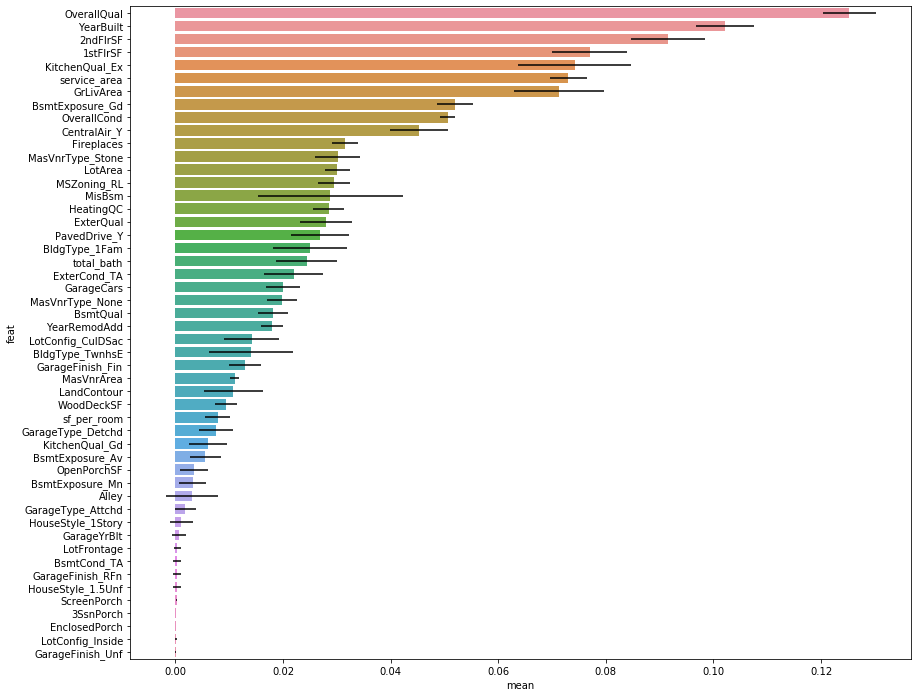

MAE: 		 0.08595
MSE: 		 0.01497
Max Error: 	 0.79487
Expl Variance: 	 0.90621


In [59]:
model = ('lasso', Lasso(alpha=0.0006, tol=0.0009, positive=True))
params = {'alpha':0.0006, 'positive':'True', 'tol': 0.0009}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

It is interesting to notice, for example, that `CentralAir_N` had a negative coefficient and now its coefficient is set to 0 and `CentralAir_Y` pops up with a larger positive coefficient now. The same happens for `PavedDrive_Y` and `PavedDrive_N`.

The very counteintuitive coefficient is the one for `MisBsmt` but, again, we also observe a larger uncertainty.

Bringing the regularization to an extreme value we see how many coefficients are set to 0, compromising the model but showing which one are the extremely relevant features.

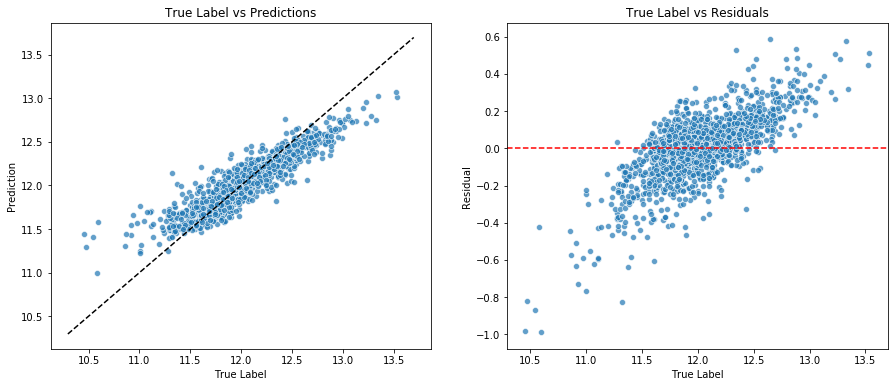

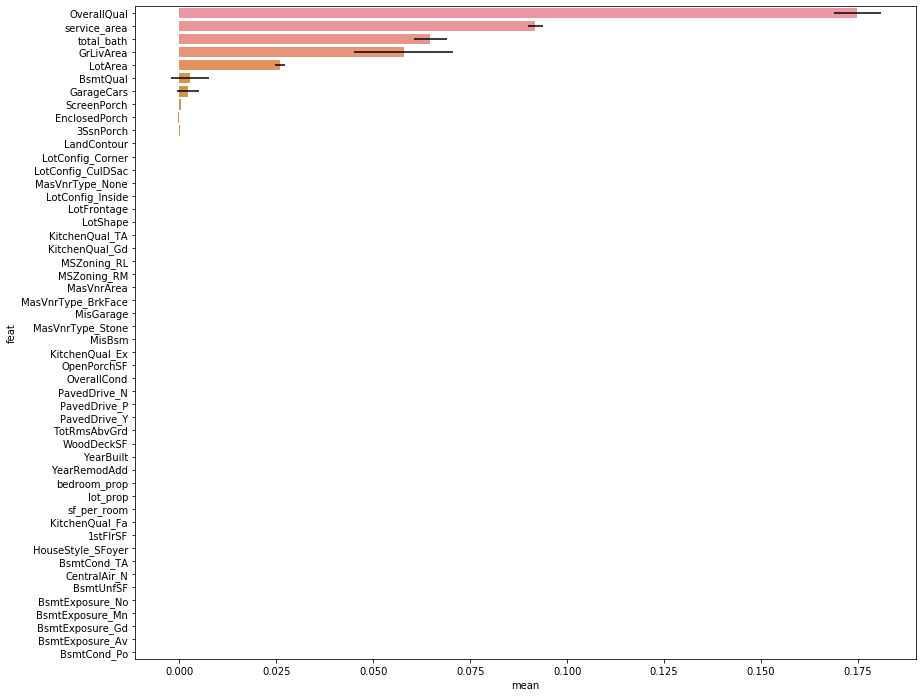

MAE: 		 0.12633
MSE: 		 0.03068
Max Error: 	 0.98815
Expl Variance: 	 0.80784


In [60]:
model = ('lasso', Lasso(alpha=0.05, tol=0.0009))
params = {'alpa':0.05, 'tol': 0.0009}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

# Conclusion

We have seen how, with the synthetic data at hand, adding a regularizing term to our model is not generally helping. However, the regularization is becoming more important when the number of training instances is limited.

In general, the higher is the regularizing parameter, the less the model is learning the data. This can help the predictive power of a model that was previously focusing on the wrong things. The training or prediction times are not affected by the presence or the magnitude of the regularization.

This type of regularization can be used for feature selection but we observe how the number of parameters set to 0 can increase quite dramatically in some cases, making the model way too simple for our scope.

Once again, finding the right value for `alpha` is enough for tuning our model properly but the sklearn implementation allows for several interesting options. For example, we can force the model to have only positive coefficients, very useful for cases where our domain knowledge suggests so. Other options may influence the speed of the model without significantly affecting its accuracy.

The summary of the models' results is the following

In [3]:
df = pd.read_csv(lab_book)
df = df[df.Model=='Lasso'].copy()
df.head()

Date  Model       Parameters                      Target Variables  \
53  18/03/2020  Lasso     {'alpha': 1}      10_feat_10_inf_nonoise       all   
54  18/03/2020  Lasso     {'alpha': 1}        10_feat_10_inf_noise       all   
55  18/03/2020  Lasso  {'alpha': 0.55}       100_feat_65_inf_noise       all   
56  18/03/2020  Lasso     {'alpha': 1}  100_feat_65_inf_noise_rank       all   
57  18/03/2020  Lasso     {'alpha': 1}      10_feat_10_inf_nonoise       all   

    N_instances         MAE            MSE    Max_error  Explained_var  
53       100000    2.525553      10.036854    12.861337       0.999798  
54       100000  159.176429   39913.496361   870.553531       0.553259  
55       100000  359.491618  202607.061051  1937.260280       0.489136  
56       100000    0.932975       1.365112     5.064188      -0.000014  
57          300    2.652366      10.934404     9.510221       0.999790

In [4]:
df[df.Target == 'tar_lin_full']

Date  Model                          Parameters        Target  \
59  18/03/2020  Lasso                        {'alpha': 1}  tar_lin_full   
60  18/03/2020  Lasso                        {'alpha': 1}  tar_lin_full   
61  18/03/2020  Lasso                      {'alpha': 2.5}  tar_lin_full   
62  18/03/2020  Lasso  {'alpha': 0.5, 'positive': 'True'}  tar_lin_full   
63  18/03/2020  Lasso                        {'alpha': 1}  tar_lin_full   

     Variables  N_instances        MAE          MSE   Max_error  Explained_var  
59         all        10000   8.514778   113.865843   42.254145       0.966964  
60         all          100  13.087127   250.537343   42.053024       0.938495  
61         all          100  10.542181   160.453608   34.029270       0.961480  
62         all        10000  40.440927  2639.310227  224.458729       0.216440  
63  unobserved        10000  15.893782   369.324824   57.930131       0.887408

With a target generated linearly with 100 features we observe that

* Moving from 10000 to 100 observations leads to +53% in MAE, +120% in MSE, no relevant change in Max Error, and -7% in explained variance. This is a lower drop with respect to the unregularized experiment of Notebook 3 and to the one with $L_2$ regularization of Notebook 4. 
* With a higher regularization, indeed, the change is +23% in MAE, +40% in MSE, -19% in Max Error, and -0.5% in explained variance.
* Removing 10% of the features leads to +85% in MAE, +224% in MSE, +37% in Max Error, and -8% in explained variance, slightly better than the $L_2$ regularized case


In [5]:
df[df.Target == 'tar_lin_half']

Date  Model      Parameters        Target   Variables  N_instances  \
64  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half       exact        10000   
65  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half       exact          100   
66  18/03/2020  Lasso  {'alpha': 0.6}  tar_lin_half       exact          100   
67  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half         all        10000   
68  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half         all          100   
69  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half    exact-10        10000   
70  18/03/2020  Lasso    {'alpha': 1}  tar_lin_half  unobserved        10000   

          MAE          MSE   Max_error  Explained_var  
64   8.504297   113.880635   44.987003       0.994846  
65  10.170697   156.580986   32.256894       0.991865  
66   8.820190   125.047438   27.348368       0.994541  
67   8.716462   118.976610   42.169786       0.994560  
68  11.304544   213.999539   38.928240       0.987682  
69  32.477734  1446.551424   97.252335       0.933868  
70  34.370069  1617.617694  101.033181       0.926342

With a target generated linearly with 50 features we observe that

* Moving from 10000 to 100 observation leads to +4% in MAE, +10% of MSE, -39% in Max Error, and nearly identical explained variance. This is a staggering result that suggests once again that this type of regularization can help in reducing large errors with a limited amoung of observations.
* If we add 50 extra features, we get a very similar perfomance.
* We again see that the regularization is helpful when the number of observations is reduced, but the drop in performance is more significant.
* On the other hand, it does not help once that some important features are missing.

In [6]:
df[df.Target == 'tar_lin_10']

Date  Model    Parameters      Target   Variables  N_instances  \
71  18/03/2020  Lasso  {'alpha': 1}  tar_lin_10       exact        10000   
72  18/03/2020  Lasso  {'alpha': 1}  tar_lin_10       exact          100   
73  18/03/2020  Lasso  {'alpha': 1}  tar_lin_10         all        10000   
74  18/03/2020  Lasso  {'alpha': 1}  tar_lin_10    exact-10        10000   
75  18/03/2020  Lasso  {'alpha': 1}  tar_lin_10  unobserved        10000   

         MAE       MSE  Max_error  Explained_var  
71  1.250703  2.452262   6.466910       0.957271  
72  1.260404  2.399015   4.351740       0.947459  
73  1.239602  2.424380   5.830335       0.957509  
74  1.568588  3.791528   7.044136       0.933516  
75  1.237165  2.414586   6.184894       0.958243

With a target generated linearly with 10 features we observe a worse performance than the one of the unregularized model because the model is setting too 0 important coefficients. it has to be noticed, however, how the perfomance seems to be uninfluenced by the removal of observations or of features.

The same cannot be said about the prediction of the target variable generated non-linearly, here it is performing better than all the previous models and the drop in perfomance due to the reduced number of observation is much less evident.

In [7]:
df[df.Target == 'tar_nonlin_10']

Date  Model      Parameters         Target Variables  N_instances  \
76  18/03/2020  Lasso    {'alpha': 1}  tar_nonlin_10       all        10000   
77  18/03/2020  Lasso    {'alpha': 1}  tar_nonlin_10       all          100   
78  18/03/2020  Lasso  {'alpha': 2.1}  tar_nonlin_10       all          100   

          MAE         MSE   Max_error  Explained_var  
76  12.688409  296.875728  181.689209       0.979982  
77  21.342249  695.123113   61.737214       0.956612  
78  22.188382  791.224389  114.022306       0.955583